## Setup

In [55]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.status()

In [56]:
using CairoMakie
using Carlo.ResultTools
using CarloAnalysis
using DataFrames
using HDF5
using JLD2
using LinearAlgebra
using PeriodicArrays
using StaticArrays

In [80]:
etak_tranform.(r.data[:, :etak_corrs])

33-element Vector{Vector{Matrix{Complex{Measurements.Measurement{Float64}}}}}:
 [[0.000425 ± 2.4e-5 + 0.0 ± 0.0im 0.000371 ± 1.3e-5 + 0.0 ± 0.0im … 0.0002781 ± 6.0e-6 + 0.0 ± 0.0im 0.000371 ± 1.3e-5 + 0.0 ± 0.0im; 0.000398 ± 1.0e-5 + 0.0 ± 0.0im 0.0003846 ± 7.8e-6 + 0.0 ± 0.0im … 0.0002406 ± 5.1e-6 + 0.0 ± 0.0im 0.0003251 ± 7.8e-6 + 0.0 ± 0.0im; … ; 0.0003384 ± 7.7e-6 + 0.0 ± 0.0im 0.000261 ± 4.8e-6 + 0.0 ± 0.0im … 0.0003322 ± 7.8e-6 + 0.0 ± 0.0im 0.0003638 ± 9.5e-6 + 0.0 ± 0.0im; 0.000398 ± 1.0e-5 + 0.0 ± 0.0im 0.0003251 ± 7.8e-6 + 0.0 ± 0.0im … 0.000318 ± 9.4e-6 + 0.0 ± 0.0im 0.0003846 ± 7.8e-6 + 0.0 ± 0.0im], [-2.4e-6 ± 6.6e-6 + 0.0 ± 0.0im -3.4e-6 ± 1.1e-5 + 3.009883131023733e-6 ± 0.0im … 5.7e-6 ± 8.9e-6 - 7.87233328259451e-6 ± 0.0im -3.4e-6 ± 1.1e-5 - 3.009883131023733e-6 ± 0.0im; -1.5e-5 ± 9.3e-6 + 3.173610619273105e-7 ± 0.0im 4.9e-6 ± 1.1e-5 - 2.2761359323194115e-6 ± 0.0im … -2.63e-5 ± 5.6e-6 + 6.952531961720838e-6 ± 0.0im -2.54e-5 ± 8.4e-6 - 3.98326149114759e-6 ± 0.0im; … ; -3.

In [88]:
function etak_tranform(etak_corrs)
    result = map(Iterators.product(1:3, 1:3)) do (x, y)
        etak_corrs[:, :, x, y]
    end
    return reshape(result, (9,))
end

function separate_etaks!(data::AbstractDataFrame)
    col_names = [:ηk_xx, :ηk_yx, :ηk_zx, :ηk_xy, :ηk_yy, :ηk_zy, :ηk_xz, :ηk_yz, :ηk_zz]
    transform!(
        data,
        :etak_corrs => (corrs -> etak_tranform.(corrs)) => col_names
    )
    return nothing
end

separate_etaks! (generic function with 1 method)

In [57]:
function gen_path(Lx, Ly)
    pos = (1, 1)
    path = [pos]
    while pos[1] < div(Lx, 2) + 1
        pos = pos .+ (1, 0)
        push!(path, pos)
    end
    M_pos = length(path)
    while pos[2] < div(Ly, 3, RoundNearest) + 1
        pos = pos .+ (1, 2)
        push!(path, pos)
    end
    K_pos = length(path)
    while pos[1] > 2
        pos = pos .- (2, 1)
        push!(path, pos)
    end
    return (path, M_pos, K_pos)
end

gen_path (generic function with 1 method)

In [58]:
function generate_spins(jobname, task_no)
    fig = Figure(size=(800, 400))

    task_str = lpad(task_no, 4, "0")
    h5open("../jobs/$jobname.data/task$task_str/run0001.dump.h5") do file
        spins = map(
            t -> [t[:data][1], t[:data][2], t[:data][3]],
            read(file, "simulation/spins")
        )
        spin_xs = map(v -> v[1], spins)
        spin_ys = map(v -> v[2], spins)
        spin_zs = map(v -> v[3], spins)
        Lx, Ly = size(spins)
        fig[1,1] = Axis(fig; title="Spins", backgroundcolor="black")
        strength = vec(spin_zs)
        arrows2d!(1:Lx, 1:Ly, spin_xs, spin_ys, lengthscale=0.5, align=:center, color=strength,
                  colorrange=(-1, 1))

        ηs = map(
            t -> [t[:data][1], t[:data][2], t[:data][3]],
            read(file, "simulation/etas")
        )
        η_xs = getindex.(ηs, 1)
        η_ys = getindex.(ηs, 2)
        η_zs = getindex.(ηs, 3)
        Lx, Ly = size(ηs)
        fig[1,2] = Axis(fig; title="ηs", backgroundcolor="black")
        strength = vec(η_zs)
        arrows2d!(1:Lx, 1:Ly, η_xs, η_ys, lengthscale=0.5, align=:center, color=strength,
                  colorrange=(-1, 1))
    end

    return fig
end

generate_spins (generic function with 1 method)

## AFM-FE Phase Border

In [4]:
border_results = JobResult("../jobs", "afm-fe")

JobResult("../jobs", "afm-fe", 17×23 DataFrame
 Row │ ηz                T        savefreq  _ll_sweep_time    ηxy              ⋯
     │ Measurem…         Float64  Int64     Measurem…         Measurem…        ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ -0.00053±0.0001     0.01       2000  0.000439±1.6e-5   0.999903±1.1e-6  ⋯
   2 │  0.00023±0.00018    0.025      2000  0.000445±1.9e-5   0.999786±2.5e-6
   3 │  0.00028±0.00028    0.05       2000  0.000434±1.2e-5   0.41±0.11
   4 │ -0.00023±0.00024    0.075      2000  0.0004348±8.5e-6  0.05994±0.00081
   5 │ -0.0002±0.00029     0.1        2000  0.0004314±9.4e-6  0.241±0.089      ⋯
   6 │ -0.00028±0.00019    0.125      2000  0.0004382±7.5e-6  0.08±0.019
   7 │  0.00018±0.00037    0.15       2000  0.000473±2.3e-5   0.06022±0.00087
   8 │  0.00011±0.00037    0.175      2000  0.0004338±8.7e-6  0.06004±0.00059
  ⋮  │        ⋮             ⋮        ⋮             ⋮                 ⋮         ⋱
  11 │  3.

In [5]:
border_results[[:_ll_sweep_time, :_ll_measure_time]]

Row,_ll_sweep_time,_ll_measure_time
,Measurem…,Measurem…
1,0.000439±1.6e-5,0.000123±3.7e-5
2,0.000445±1.9e-5,4.52e-5±1.5e-6
3,0.000434±1.2e-5,4.247e-5±6.1e-7
4,0.0004348±8.5e-6,4.207e-5±1.7e-7
5,0.0004314±9.4e-6,4.183e-5±1.8e-7
6,0.0004382±7.5e-6,4.304e-5±4.3e-7
7,0.000473±2.3e-5,4.71e-5±2.8e-6
8,0.0004338±8.7e-6,4.286e-5±2.7e-7
9,0.0004329±9.0e-6,4.277e-5±5.0e-7


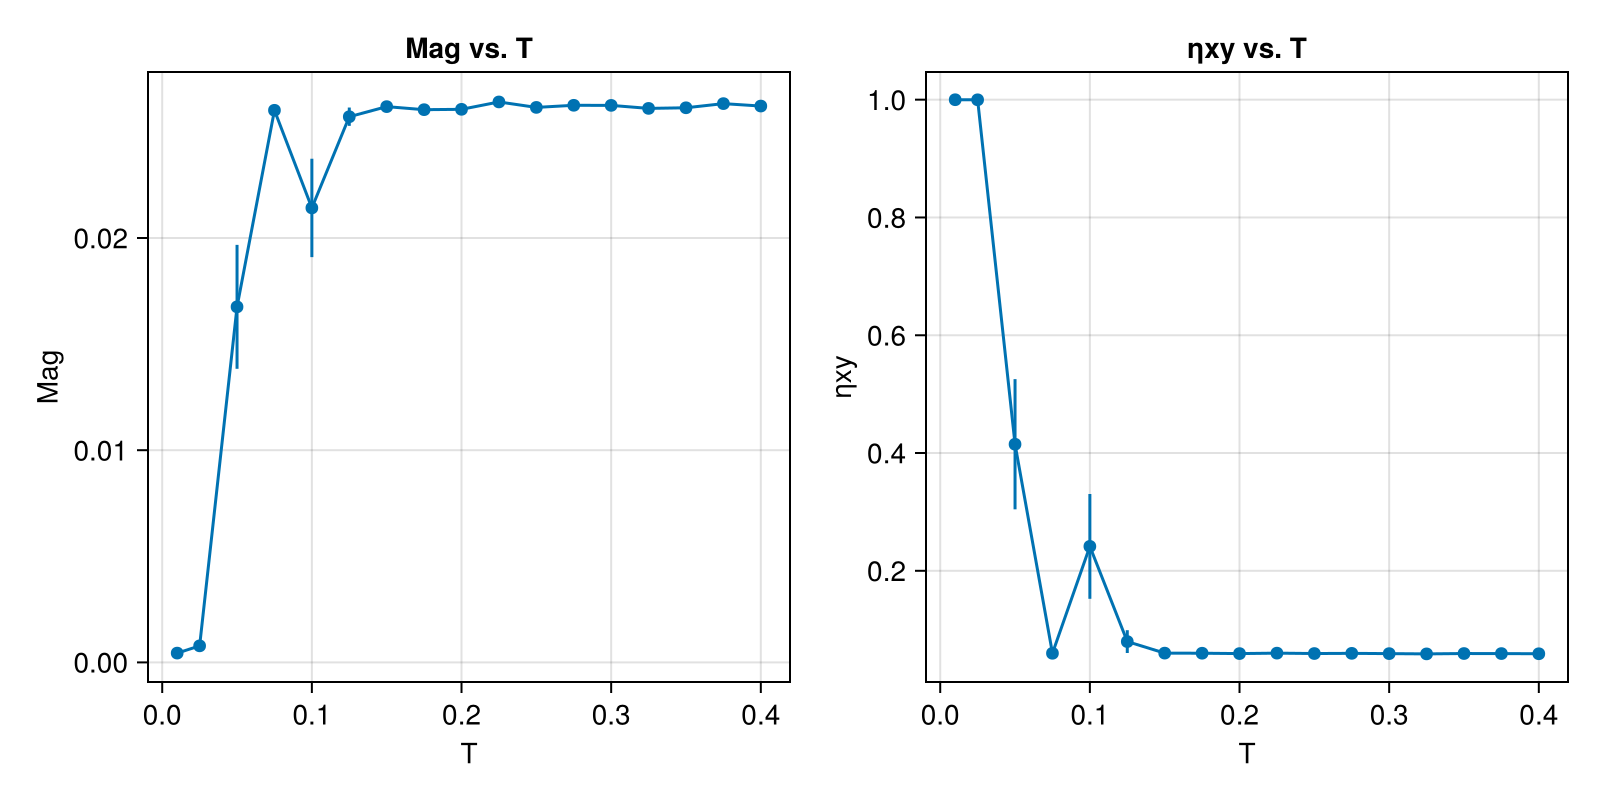

In [6]:
CairoMakie.activate!()

fig = Figure(size=(800, 400))
fig[1,1] = ax_s = Axis(fig, title="Mag vs. T", xlabel="T", ylabel="Mag")
generate_plot!(ax_s, :T, :Mag, border_results; line=true)
fig[1,2] = ax_η = Axis(fig, title="ηxy vs. T", xlabel="T", ylabel="ηxy")
generate_plot!(ax_η, :T, :ηxy, border_results; line=true)
fig

In [7]:
border_mctimes = get_mctime_data(border_results, :Mag, :ηxy)

17-element Vector{DataFrame}:
 400×2 DataFrame
 Row │ Mag          ηxy      
     │ Float64      Float64  
─────┼───────────────────────
   1 │ 0.000271464  0.999896
   2 │ 0.000182794  0.999896
   3 │ 0.000197197  0.999896
   4 │ 0.000229268  0.999896
   5 │ 0.000293473  0.999896
   6 │ 0.000249069  0.999896
   7 │ 0.000243349  0.999896
   8 │ 0.000253358  0.999896
  ⋮  │      ⋮          ⋮
 394 │ 0.000330045  0.999902
 395 │ 0.000179694  0.999902
 396 │ 0.000252888  0.999903
 397 │ 0.000313207  0.999903
 398 │ 0.000338003  0.999904
 399 │ 0.000435715  0.999904
 400 │ 0.000489401  0.999904
             385 rows omitted
 400×2 DataFrame
 Row │ Mag          ηxy      
     │ Float64      Float64  
─────┼───────────────────────
   1 │ 0.000390099  0.999771
   2 │ 0.000718606  0.999772
   3 │ 0.000845632  0.999772
   4 │ 0.000760826  0.999771
   5 │ 0.000983771  0.999771
   6 │ 0.000757555  0.999771
   7 │ 0.00055558   0.99977
   8 │ 0.000436167  0.99977
  ⋮  │      ⋮          ⋮
 394 │ 0.00

In [8]:
GLMakie.activate!()

fig = Figure()
fig[1,1] = ax = Axis(fig, title="ηxy vs. Bin #", xlabel="Bin #", ylabel="ηxy")
sg = SliderGrid(
    fig[2, 1],
    (label="Task #", range=1:17, format="{:.1f}", startvalue=1, update_while_dragging=false)
)
slider = sg.sliders[1]
mcdata = lift(slider.value) do i
    border_mctimes[i][:, :ηxy]
end
on(mcdata) do mcdata
    empty!(ax)
    lines!(ax, 1:400, mcdata)
    autolimits!(ax)
end
fig

## AFM-FE Phase Center

In [33]:
center_results = JobResult("../jobs", "afm-fe-center")

JobResult("../jobs", "afm-fe-center", 13×24 DataFrame
 Row │ ηz               T        etak_corrs                         _ll_sweep_ ⋯
     │ Measurem…        Float64  Array…                             Measurem…  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 2.6e-6±5.5e-5      0.01   Complex{Measurement{Float64}}[66…  0.000408±1 ⋯
   2 │ 0.000193±9.5e-5    0.025  Complex{Measurement{Float64}}[66…  0.0003879±
   3 │ 0.0005±0.00021     0.05   Complex{Measurement{Float64}}[66…  0.0004052±
   4 │ 0.0049±0.0017      0.075  Complex{Measurement{Float64}}[27…  0.0004096±
   5 │ 0.0051±0.0016      0.1    Complex{Measurement{Float64}}[43…  0.0004256± ⋯
   6 │ 0.0052±0.0017      0.125  Complex{Measurement{Float64}}[60…  0.0004145±
   7 │ 0.0047±0.0017      0.15   Complex{Measurement{Float64}}[55…  0.0004122±
   8 │ 0.0045±0.0018      0.175  Complex{Measurement{Float64}}[60…  0.0004091±
   9 │ 0.0045±0.0017      0.2    Complex{Measurement{Float64}}[59… 

In [34]:
center_results[[:_ll_sweep_time, :_ll_measure_time]]

Row,_ll_sweep_time,_ll_measure_time
,Measurem…,Measurem…
1,0.000408±1.2e-5,0.000223±4.0e-5
2,0.0003879±4.8e-6,0.0001472±6.9e-6
3,0.0004052±9.7e-6,0.00016±1.2e-5
4,0.0004096±6.1e-6,0.000163±1.1e-5
5,0.0004256±6.2e-6,0.0001709±8.6e-6
6,0.0004145±4.0e-6,0.0001511±5.4e-6
7,0.0004122±3.2e-6,0.0001482±6.3e-6
8,0.0004091±2.8e-6,0.0001416±4.0e-6
9,0.000409±3.3e-6,0.0001502±7.9e-6


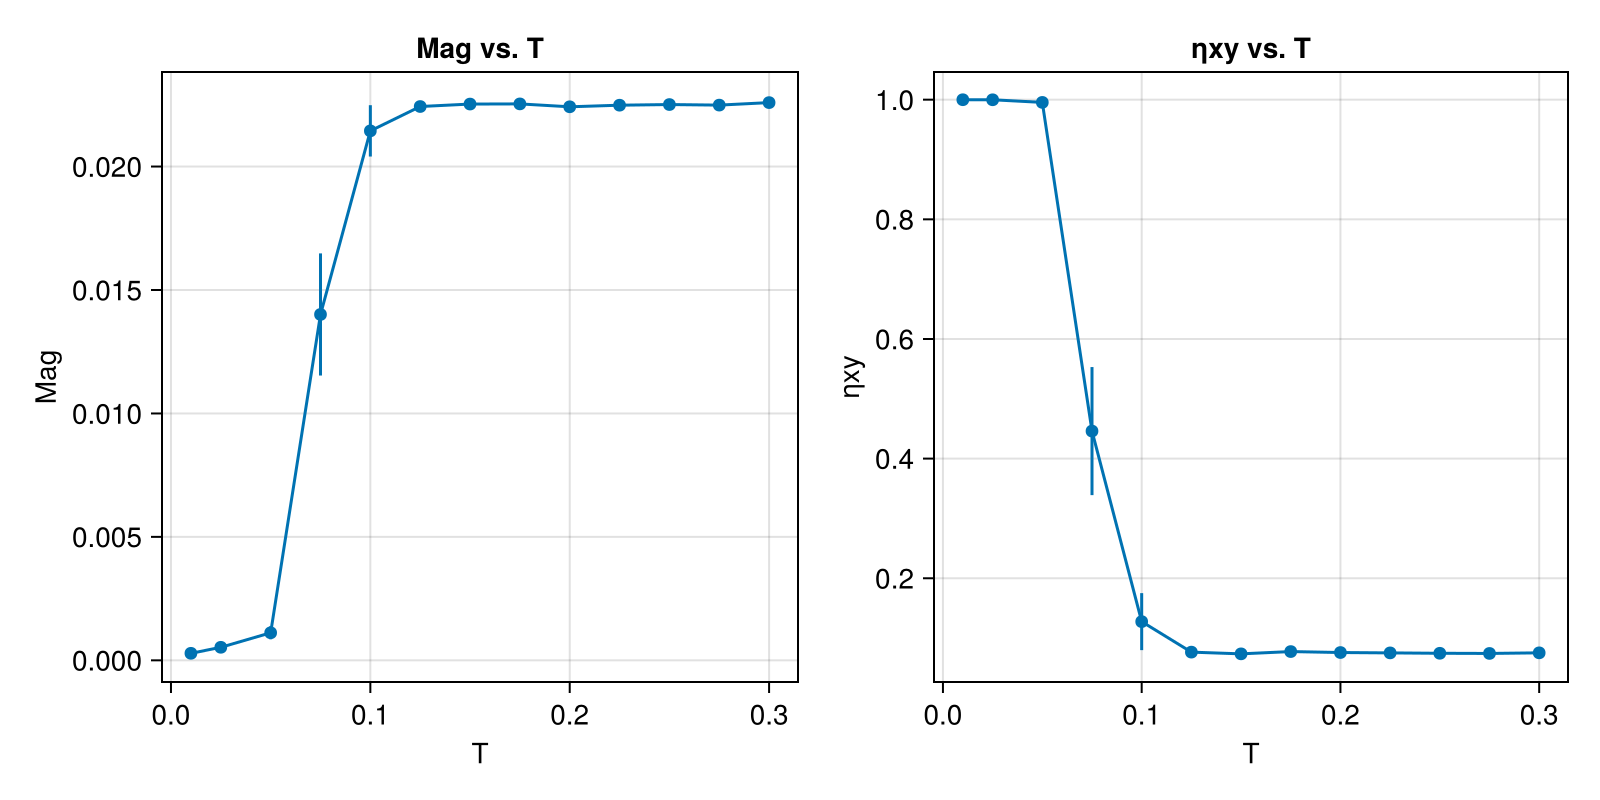

In [35]:
CairoMakie.activate!()

fig = Figure(size=(800, 400))
fig[1,1] = ax_s = Axis(fig, title="Mag vs. T", xlabel="T", ylabel="Mag")
generate_plot!(ax_s, :T, :Mag, center_results; line=true)
fig[1,2] = ax_η = Axis(fig, title="ηxy vs. T", xlabel="T", ylabel="ηxy")
generate_plot!(ax_η, :T, :ηxy, center_results; line=true)
fig

In [36]:
center_mctimes = get_mctime_data(center_results, :Mag, :ηxy)

13-element Vector{DataFrame}:
 600×2 DataFrame
 Row │ Mag          ηxy      
     │ Float64      Float64  
─────┼───────────────────────
   1 │ 0.000101422  0.999936
   2 │ 0.000103075  0.999936
   3 │ 0.000102785  0.999936
   4 │ 6.90139e-5   0.999936
   5 │ 5.67692e-5   0.999936
   6 │ 5.84821e-5   0.999936
   7 │ 5.33401e-5   0.999936
   8 │ 6.21405e-5   0.999936
  ⋮  │      ⋮          ⋮
 594 │ 0.000214016  0.999947
 595 │ 0.00019393   0.999947
 596 │ 0.000217828  0.999946
 597 │ 0.000215592  0.999946
 598 │ 0.000213152  0.999946
 599 │ 0.000233348  0.999946
 600 │ 0.000237053  0.999947
             585 rows omitted
 600×2 DataFrame
 Row │ Mag          ηxy      
     │ Float64      Float64  
─────┼───────────────────────
   1 │ 0.000278329  0.999876
   2 │ 0.000291858  0.999876
   3 │ 0.000323262  0.999876
   4 │ 0.00037634   0.999878
   5 │ 0.000480742  0.999877
   6 │ 0.000571824  0.999877
   7 │ 0.000488634  0.999877
   8 │ 0.000621363  0.999875
  ⋮  │      ⋮          ⋮
 594 │ 0.

In [ ]:
spink_corrs = center_results[:spink_corrs]

13-element Vector{Matrix{Measurements.Measurement{Float64}}}:
 [1.19e-7 ± 3.4e-8 2.68e-7 ± 4.0e-8 … 2.12e-7 ± 2.7e-8 2.68e-7 ± 4.0e-8; 1.07e-7 ± 2.0e-8 1.41e-7 ± 1.1e-8 … 2.45e-7 ± 2.8e-8 1.78e-7 ± 2.3e-8; … ; 2.1e-7 ± 2.0e-8 1.5e-7 ± 1.8e-8 … 1.54e-7 ± 2.4e-8 1.51e-7 ± 1.9e-8; 1.07e-7 ± 2.0e-8 1.78e-7 ± 2.3e-8 … 1.27e-7 ± 1.1e-8 1.41e-7 ± 1.1e-8]
 [3.68e-7 ± 9.0e-8 3.88e-7 ± 5.2e-8 … 4.11e-7 ± 5.2e-8 3.88e-7 ± 5.2e-8; 4.48e-7 ± 6.3e-8 3.73e-7 ± 3.4e-8 … 4.32e-7 ± 7.7e-8 3.48e-7 ± 6.0e-8; … ; 4.41e-7 ± 5.2e-8 4.63e-7 ± 4.7e-8 … 3.26e-7 ± 4.0e-8 3.1e-7 ± 2.8e-8; 4.48e-7 ± 6.3e-8 3.48e-7 ± 6.0e-8 … 3.97e-7 ± 5.1e-8 3.73e-7 ± 3.4e-8]
 [2.8e-6 ± 1.7e-6 2.4e-6 ± 1.2e-6 … 1.94e-6 ± 8.6e-7 2.4e-6 ± 1.2e-6; 2.6e-6 ± 1.3e-6 3.0e-6 ± 1.8e-6 … 3.1e-6 ± 1.5e-6 2.7e-6 ± 1.3e-6; … ; 2.9e-6 ± 1.6e-6 3.5e-6 ± 1.9e-6 … 3.3e-6 ± 2.0e-6 3.0e-6 ± 1.6e-6; 2.6e-6 ± 1.3e-6 2.7e-6 ± 1.3e-6 … 2.2e-6 ± 1.1e-6 3.0e-6 ± 1.8e-6]
 [0.000357 ± 6.9e-5 0.000366 ± 7.1e-5 … 0.00039 ± 7.5e-5 0.000366 ± 7.1e-5; 0.00036 ± 

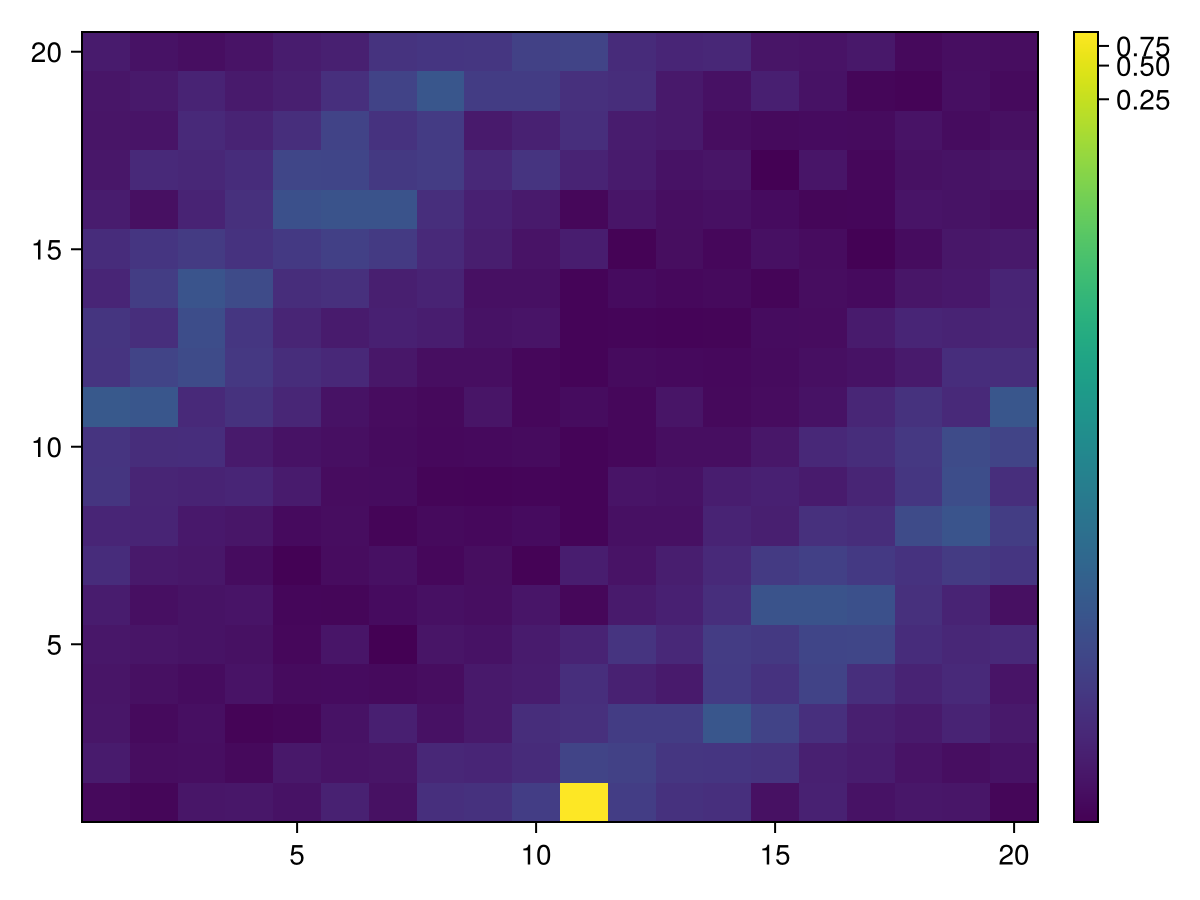

In [44]:
CairoMakie.activate!()
fig = Figure(size=(500, 500))
ax = fig[1,1] = Axis(fig; title="Spin_k")
scale = ReversibleScale(log)
fig, ax, hm = heatmap(getfield.(spink_corrs[1], :val), colorscale=scale)
Colorbar(fig[1, 2], hm)
fig

Any[(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 3), (13, 5), (14, 7), (12, 6), (10, 5), (8, 4), (6, 3), (4, 2), (2, 1)]


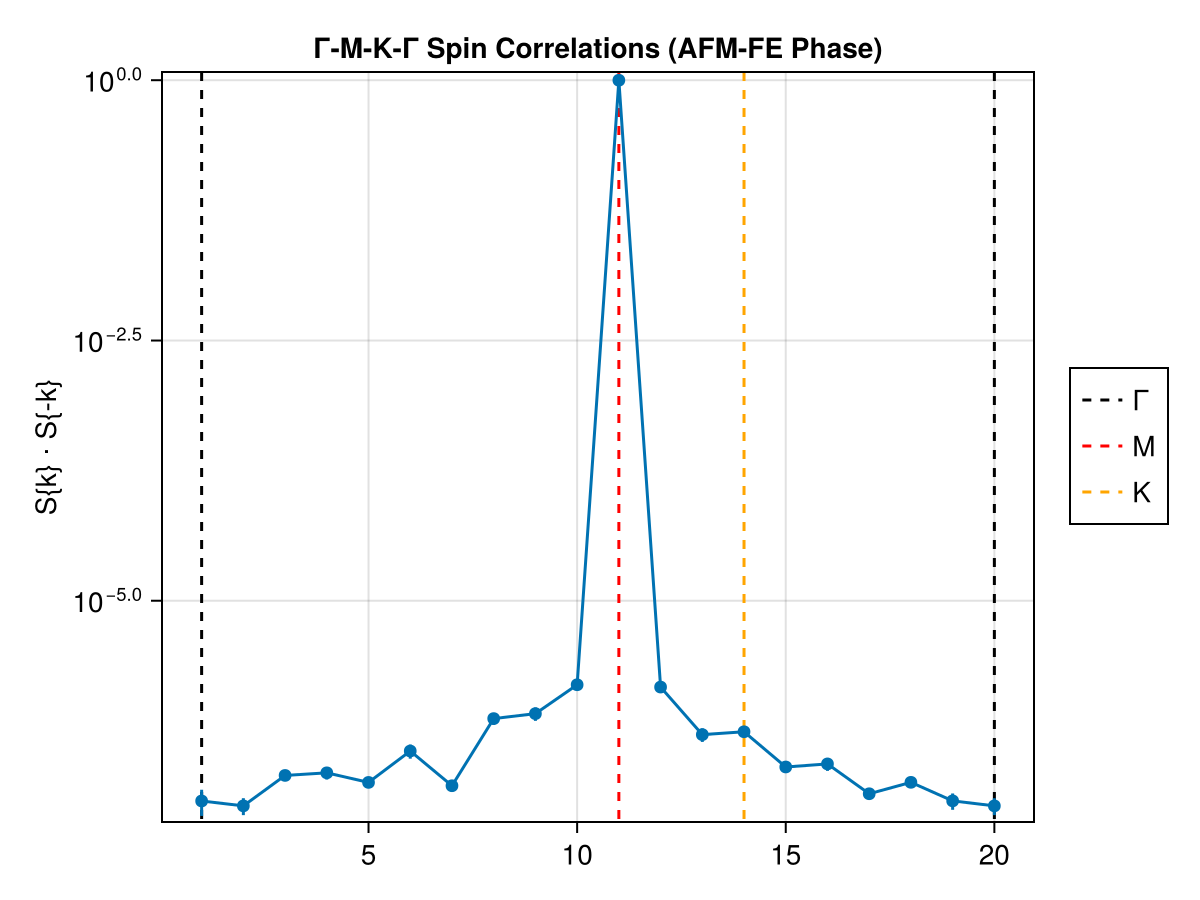

In [51]:
CairoMakie.activate!()
Lx, Ly = size(spink_corrs[1])

path = []
pos = (1, 1)
push!(path, pos)
while pos[1] < div(Lx, 2) + 1
    pos = pos .+ (1, 0)
    push!(path, pos)
end
M_pos = length(path)
while pos[2] < div(Ly, 3) + 1
    pos = pos .+ (1, 2)
    push!(path, pos)
end
K_pos = length(path)
while pos[2] > 1
    pos = pos .- (2, 1)
    push!(path, pos)
end
println(path)

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Γ-M-K-Γ Spin Correlations (AFM-FE Phase)",
    ylabel="S{k} ⋅ S{-k}",
    yscale=log10
)

min_corr = minimum(getfield.([spink_corrs[1][I...] for I in path], :val))
max_corr = maximum(getfield.([spink_corrs[1][I...] for I in path], :val))
lines!([(1, 2), (1, 1e-9)], color=:black, label="Γ", linestyle=:dash)
lines!([(M_pos, 2), (M_pos, 1e-9)], color=:red, label="M", linestyle=:dash)
lines!([(K_pos, 2), (K_pos, 1e-9)], color=:orange, label="K", linestyle=:dash)
lines!([(length(path), 2), (length(path), 1e-9)], color=:black, linestyle=:dash)

for i in [1]
    corrs = [spink_corrs[i][I...] for I in path]
    scatter!(ax, corrs)
    errorbars!(ax, 1:length(path), getfield.(corrs, :val), getfield.(corrs, :err))
    lines!(ax, corrs)
end

ylims!(ax, (0.7 * min_corr, 1.2 * max_corr))
Legend(fig[1,2], ax)
fig

## AFM-FE Etas Only

In [7]:
eta_results = JobResult("../jobs", "afm-fe-eta")

JobResult("../jobs", "afm-fe-eta", 21×23 DataFrame
 Row │ ηz               T        etak_corrs                         _ll_sweep_ ⋯
     │ Measurem…        Float64  Array…                             Measurem…  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.00063±0.00014     0.01  Complex{Measurement{Float64}}[0.…  0.0002577± ⋯
   2 │ 0.00298±0.00017     1.0   Complex{Measurement{Float64}}[0.…  0.00026124
   3 │ 0.00399±0.00015     2.0   Complex{Measurement{Float64}}[0.…  0.00026053
   4 │ 0.00513±0.00016     3.0   Complex{Measurement{Float64}}[0.…  0.00026085
   5 │ 0.00588±0.00015     4.0   Complex{Measurement{Float64}}[0.…  0.00026148 ⋯
   6 │ 0.0064±0.00014      5.0   Complex{Measurement{Float64}}[0.…  0.0002675±
   7 │ 0.00695±0.00013     6.0   Complex{Measurement{Float64}}[0.…  0.00026109
   8 │ 0.0076±0.00015      7.0   Complex{Measurement{Float64}}[0.…  0.00026083
  ⋮  │        ⋮            ⋮                     ⋮                    

In [8]:
eta_results[[:_ll_sweep_time, :_ll_measure_time]]

Row,_ll_sweep_time,_ll_measure_time
,Measurem…,Measurem…
1,0.0002577±2.0e-6,0.000188±2.3e-5
2,0.00026124±7.7e-7,0.0001641±2.0e-6
3,0.00026053±2.4e-7,0.000172±1.1e-5
4,0.00026085±1.9e-7,0.0001627±2.7e-6
5,0.00026148±3.3e-7,0.00016163±6.1e-7
6,0.0002675±3.2e-6,0.0001666±2.7e-6
7,0.00026109±3.6e-7,0.00016353±7.6e-7
8,0.00026083±2.4e-7,0.000173±1.0e-5
9,0.0002652±3.4e-6,0.000172±7.5e-6


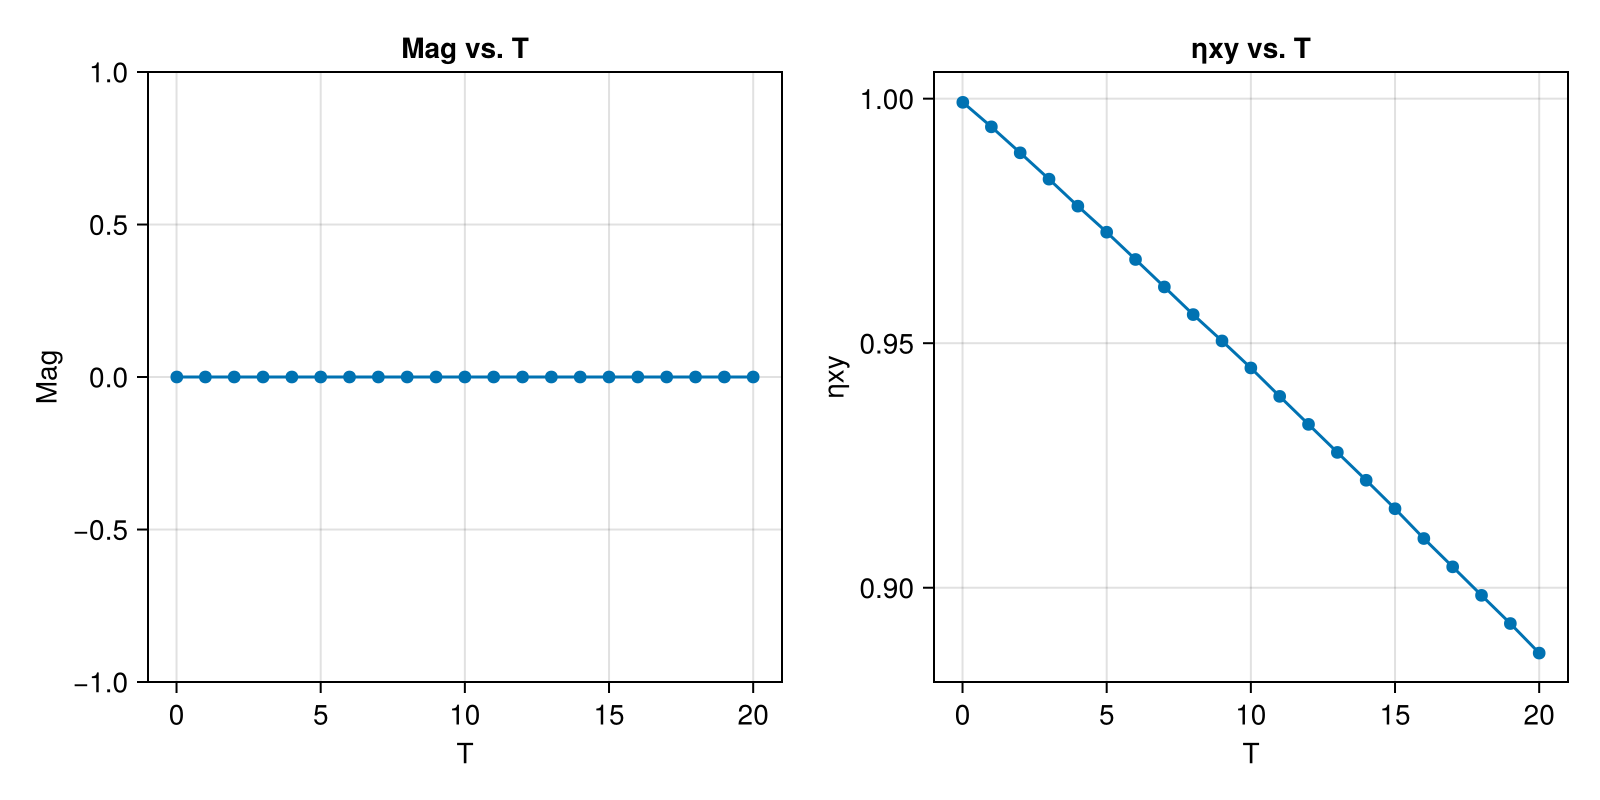

In [9]:
CairoMakie.activate!()

fig = Figure(size=(800, 400))
fig[1,1] = ax_s = Axis(fig, title="Mag vs. T", xlabel="T", ylabel="Mag")
generate_plot!(ax_s, :T, :Mag, eta_results; line=true)
fig[1,2] = ax_η = Axis(fig, title="ηxy vs. T", xlabel="T", ylabel="ηxy")
generate_plot!(ax_η, :T, :ηxy, eta_results; line=true)
fig

In [10]:
eta_mctimes = get_mctime_data(eta_results, :ηxy)

21-element Vector{DataFrame}:
 60×1 DataFrame
 Row │ ηxy      
     │ Float64  
─────┼──────────
   1 │ 0.973734
   2 │ 0.996791
   3 │ 0.998111
   4 │ 0.998687
   5 │ 0.998959
   6 │ 0.999179
   7 │ 0.99935
   8 │ 0.999437
  ⋮  │    ⋮
  54 │ 0.999905
  55 │ 0.999906
  56 │ 0.999908
  57 │ 0.99991
  58 │ 0.99991
  59 │ 0.999912
  60 │ 0.999913
 45 rows omitted
 60×1 DataFrame
 Row │ ηxy      
     │ Float64  
─────┼──────────
   1 │ 0.972792
   2 │ 0.994216
   3 │ 0.994381
   4 │ 0.99473
   5 │ 0.994684
   6 │ 0.994264
   7 │ 0.994589
   8 │ 0.994454
  ⋮  │    ⋮
  54 │ 0.994717
  55 │ 0.994782
  56 │ 0.994707
  57 │ 0.994695
  58 │ 0.994896
  59 │ 0.994584
  60 │ 0.994367
 45 rows omitted
 60×1 DataFrame
 Row │ ηxy      
     │ Float64  
─────┼──────────
   1 │ 0.969901
   2 │ 0.989391
   3 │ 0.989501
   4 │ 0.98919
   5 │ 0.988826
   6 │ 0.98873
   7 │ 0.989011
   8 │ 0.989214
  ⋮  │    ⋮
  54 │ 0.989116
  55 │ 0.989438
  56 │ 0.989012
  57 │ 0.989497
  58 │ 0.988979
  59 │ 0.98886
  

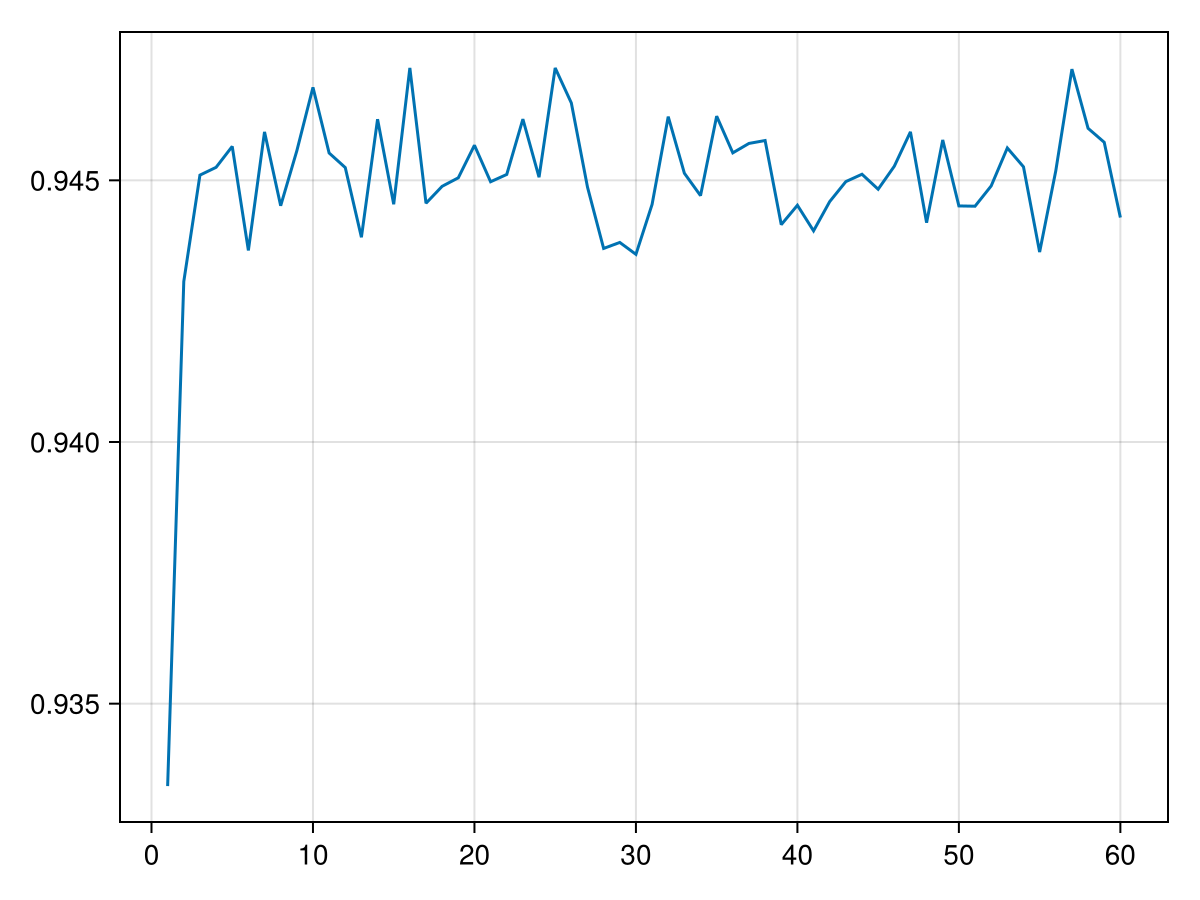

In [11]:
i = 11
fig = Figure()
ax = fig[1,1] = Axis(fig)
lines!(ax, eta_mctimes[i][:, :ηxy])
fig

Maximum correlation norm: 0.58586 ± 0.00056

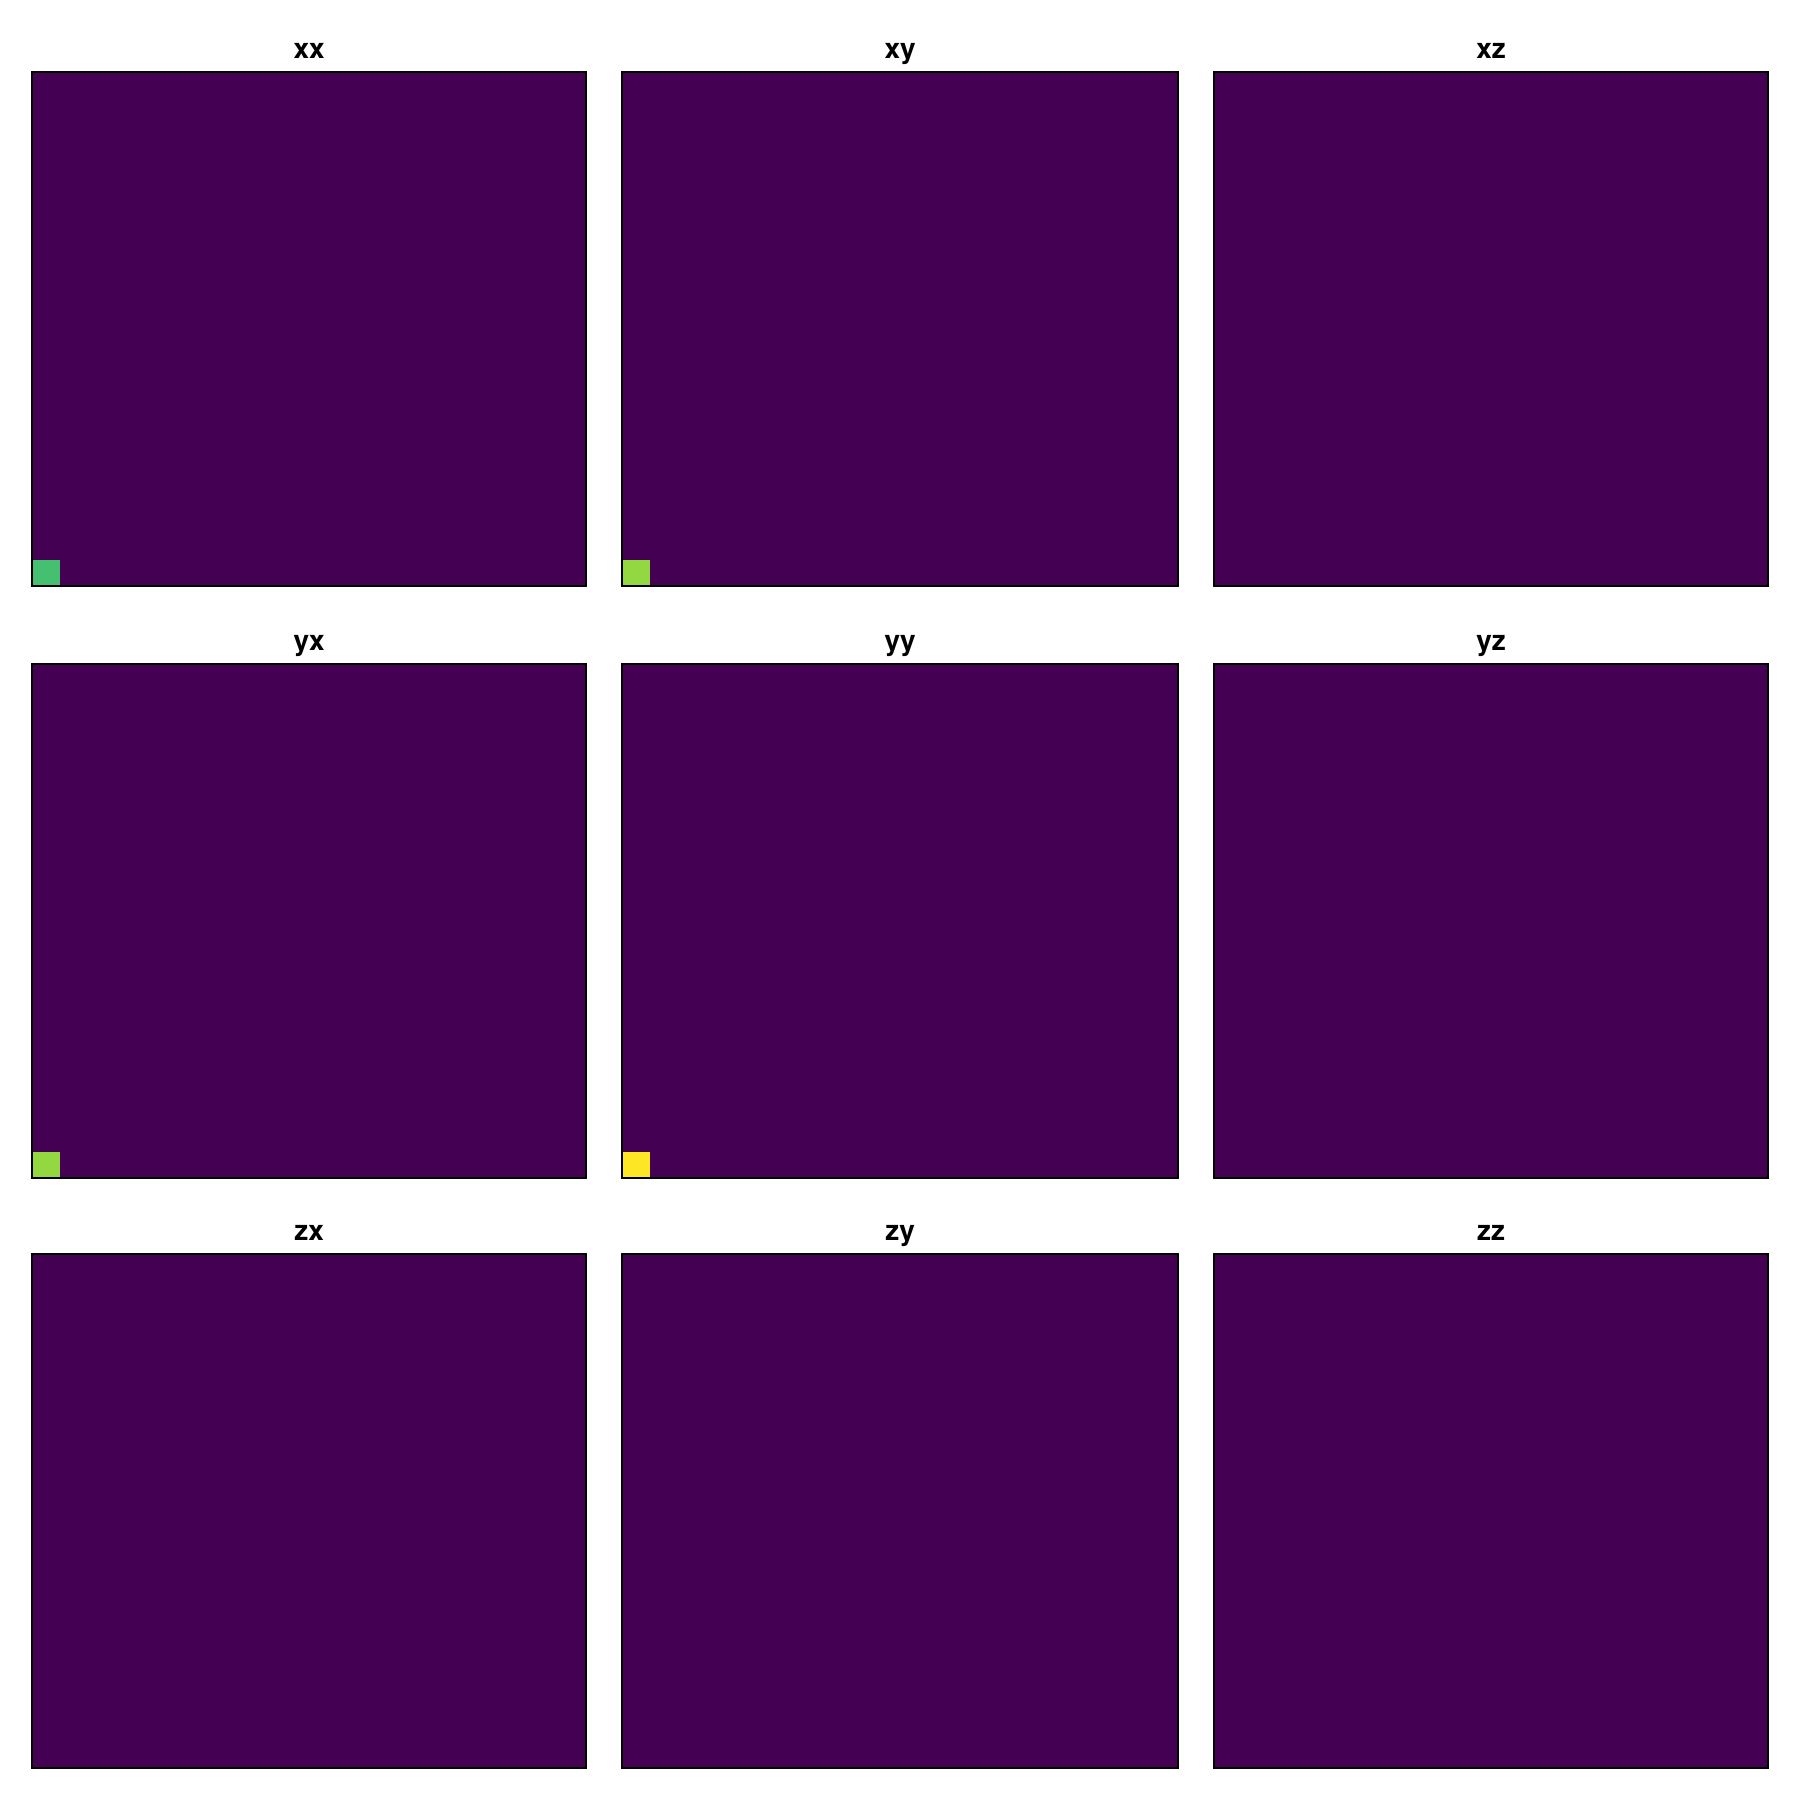

In [12]:
CairoMakie.activate!()

i = 1
Lx = 40
etak_corrs = eta_results[:etak_corrs]
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
scale = ReversibleScale(log)
corr_matrices = eachslice(etak_corrs[i], dims=(1, 2))
max_corrs = maximum(abs.(etak_corrs[i]))
min_corrs = minimum(abs.(etak_corrs[i]))
for x in 1:3
    for y in 1:3
        fig[x, y] = ax = Axis(fig, title="$(labels[x])$(labels[y])")
        corrs = getindex.(corr_matrices, x, y)
        heatmap!(ax, getfield.(abs.(corrs), :val), colorrange=(0, max_corrs.val))
        hidedecorations!(ax)
    end
end

print("Maximum correlation norm: $max_corrs")
fig

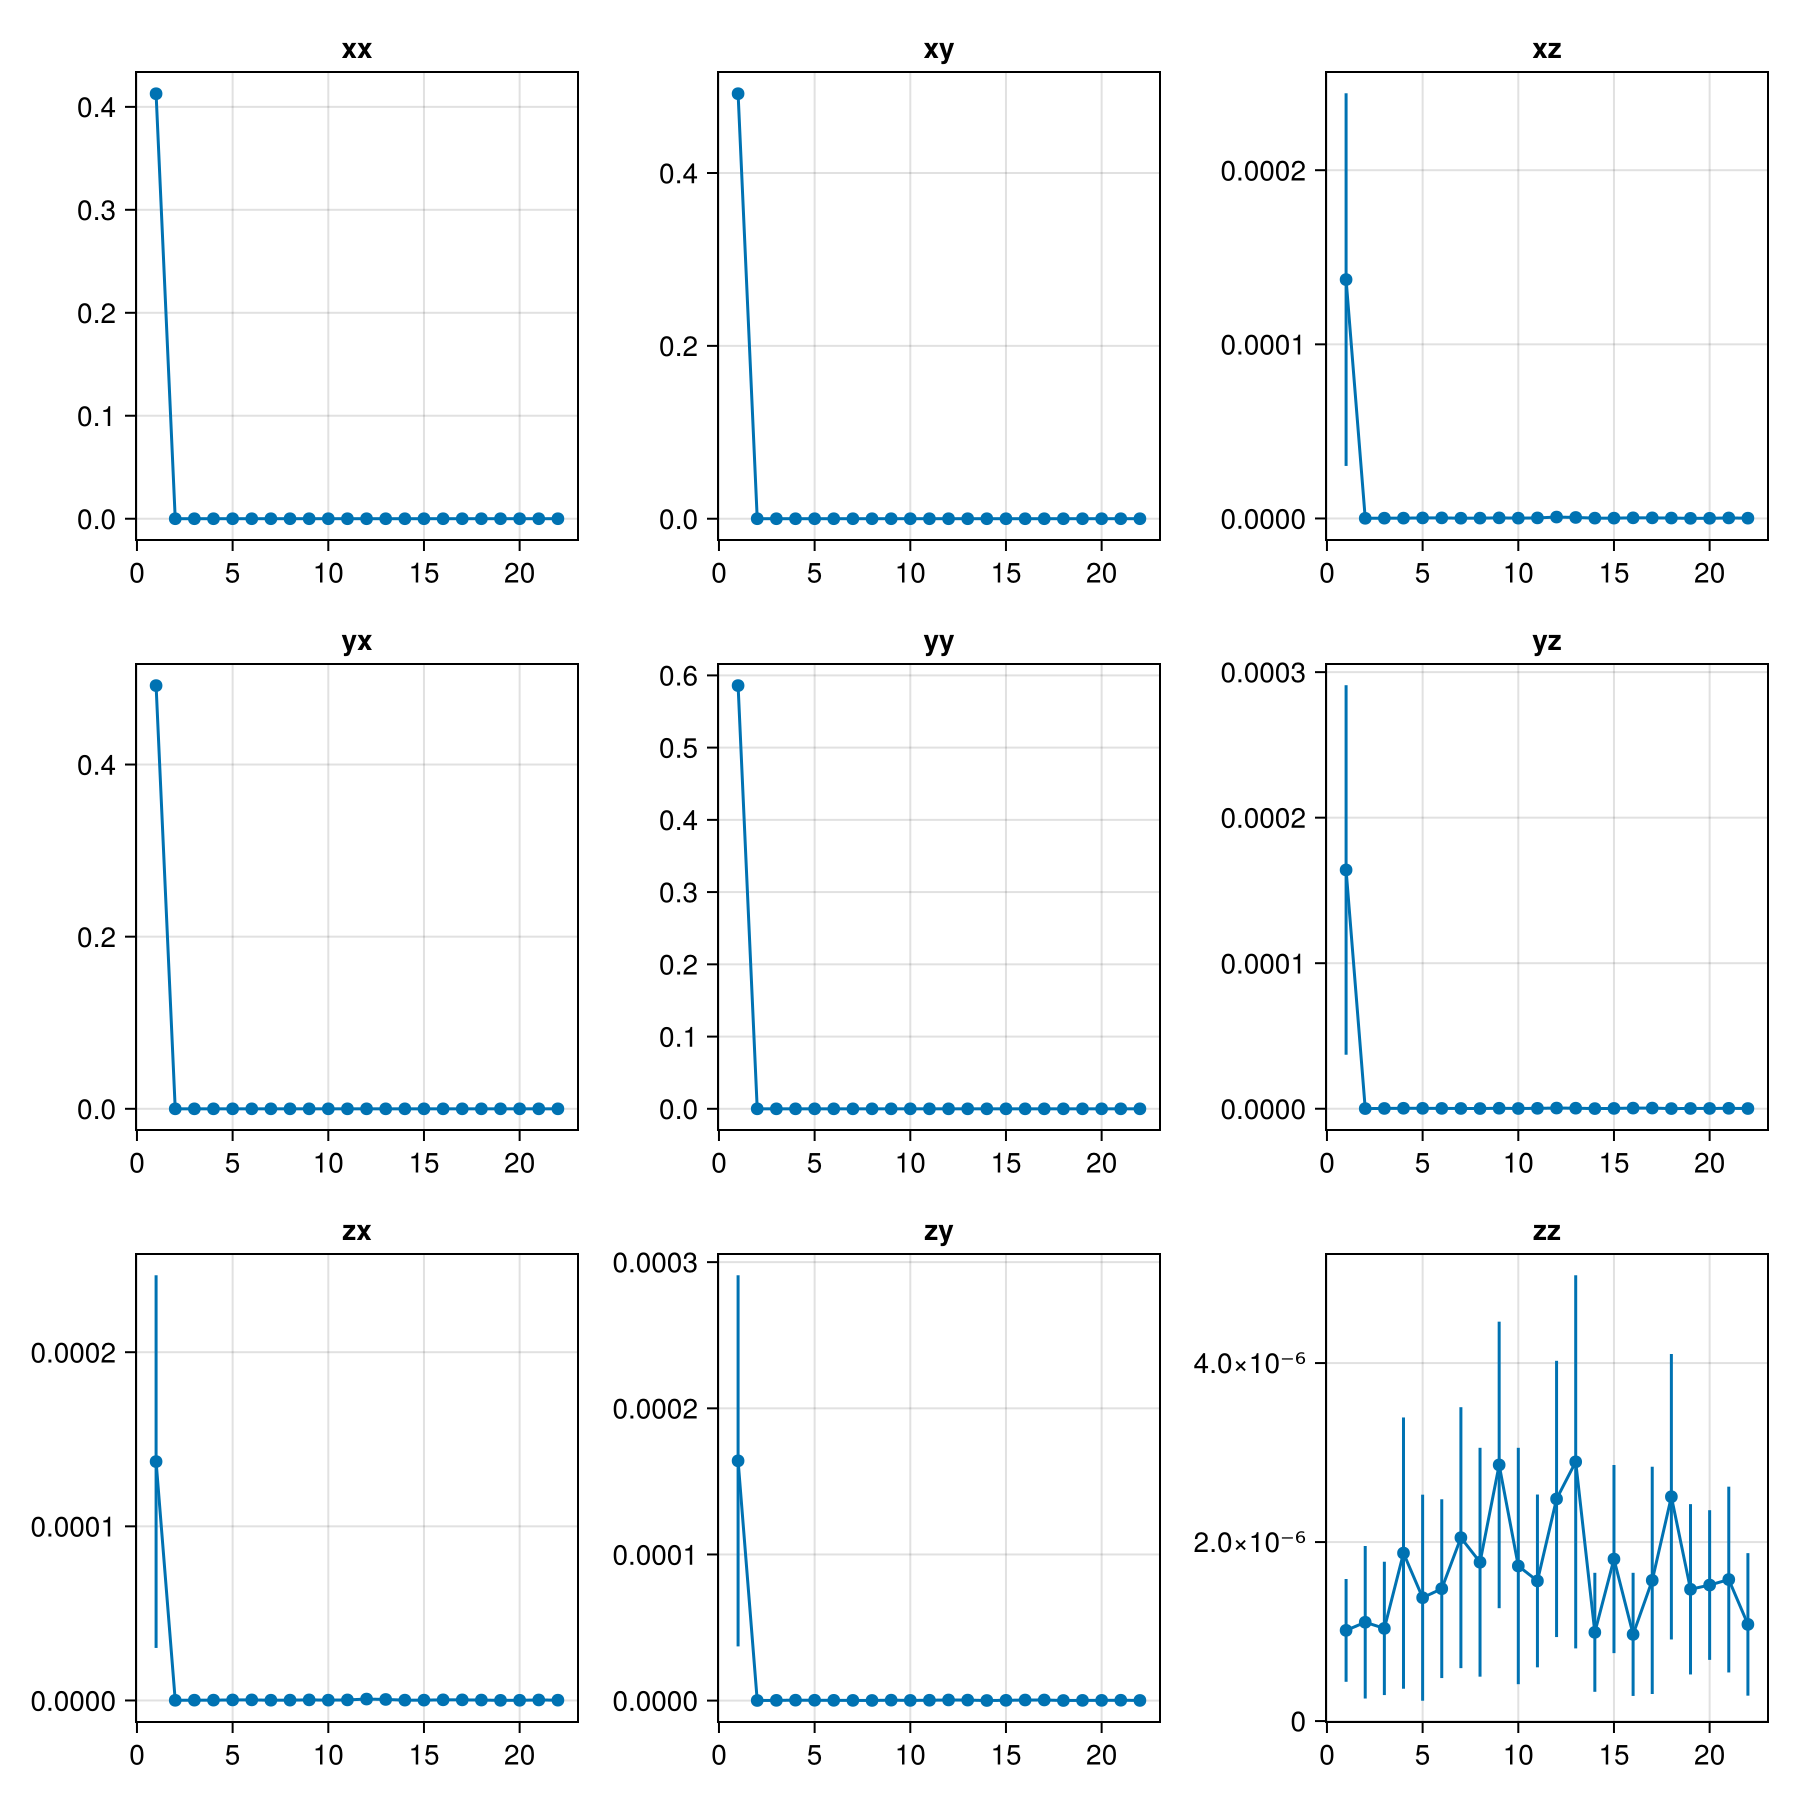

In [32]:
etak_corrs = eta_results[:etak_corrs]
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
scale = ReversibleScale(log)

axs = Matrix{Axis}(undef, 3, 3)
for x in 1:3
    for y in 1:3
        fig[x, y] = axs[x, y] = Axis(fig, title="$(labels[x])$(labels[y])")
    end
end

for i in [1]
    corr_matrices = collect(eachslice(etak_corrs[i], dims=(1, 2)))
    path, M_pos, K_pos = gen_path(size(corr_matrices)...)
    path_matrices = [corr_matrices[I...] for I in path]
    for x in 1:3
        for y in 1:3
            ax = axs[x, y]
            corrs = abs.(getindex.(path_matrices, x, y))
            corr_vals = getfield.(corrs, :val)
            corr_errs = getfield.(corrs, :err)
            scatter!(ax, corr_vals)
            lines!(ax, corr_vals)
            errorbars!(ax, 1:length(corr_vals), corr_vals, corr_errs)
        end
    end
end

fig

## Phase Center Annealed

In [45]:
anneal_results = JobResult("../jobs", "afm-fe-anneal")

JobResult("../jobs", "afm-fe-anneal", 33×23 DataFrame
 Row │ ηz               T        init_T   etak_corrs                         _ ⋯
     │ Measurem…        Float64  Float64  Array…                             M ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.01496±0.00018     0.01     10.0  Complex{Measurement{Float64}}[0.…  0 ⋯
   2 │ 0.01515±0.00013     0.05     10.0  Complex{Measurement{Float64}}[0.…  0
   3 │ 0.01526±0.00011     0.1      10.0  Complex{Measurement{Float64}}[0.…  0
   4 │ 0.01501±0.00011     0.15     10.0  Complex{Measurement{Float64}}[0.…  0
   5 │ 0.01503±0.00012     0.2      10.0  Complex{Measurement{Float64}}[0.…  0 ⋯
   6 │ 0.01502±0.00013     0.25     10.0  Complex{Measurement{Float64}}[0.…  0
   7 │ 0.01483±0.00012     0.3      10.0  Complex{Measurement{Float64}}[0.…  0
   8 │ 0.01505±0.0001      0.35     10.0  Complex{Measurement{Float64}}[0.…  0
  ⋮  │        ⋮            ⋮        ⋮                     ⋮        

In [46]:
anneal_results[[:_ll_sweep_time, :_ll_measure_time]]

Row,_ll_sweep_time,_ll_measure_time
,Measurem…,Measurem…
1,0.0004246±6.8e-6,0.000173±2.1e-5
2,0.0004239±1.9e-6,0.0001505±7.6e-6
3,0.00042552±1.4e-7,0.0001484±6.4e-6
4,0.00042313±2.4e-7,0.0001472±6.8e-6
5,0.00042021±1.6e-7,0.0001487±7.5e-6
6,0.00041887±3.7e-7,0.0001447±4.5e-6
7,0.00041801±6.7e-7,0.0001444±5.6e-6
8,0.00041688±3.8e-7,0.0001458±5.5e-6
9,0.0004246±8.0e-6,0.0001515±7.8e-6


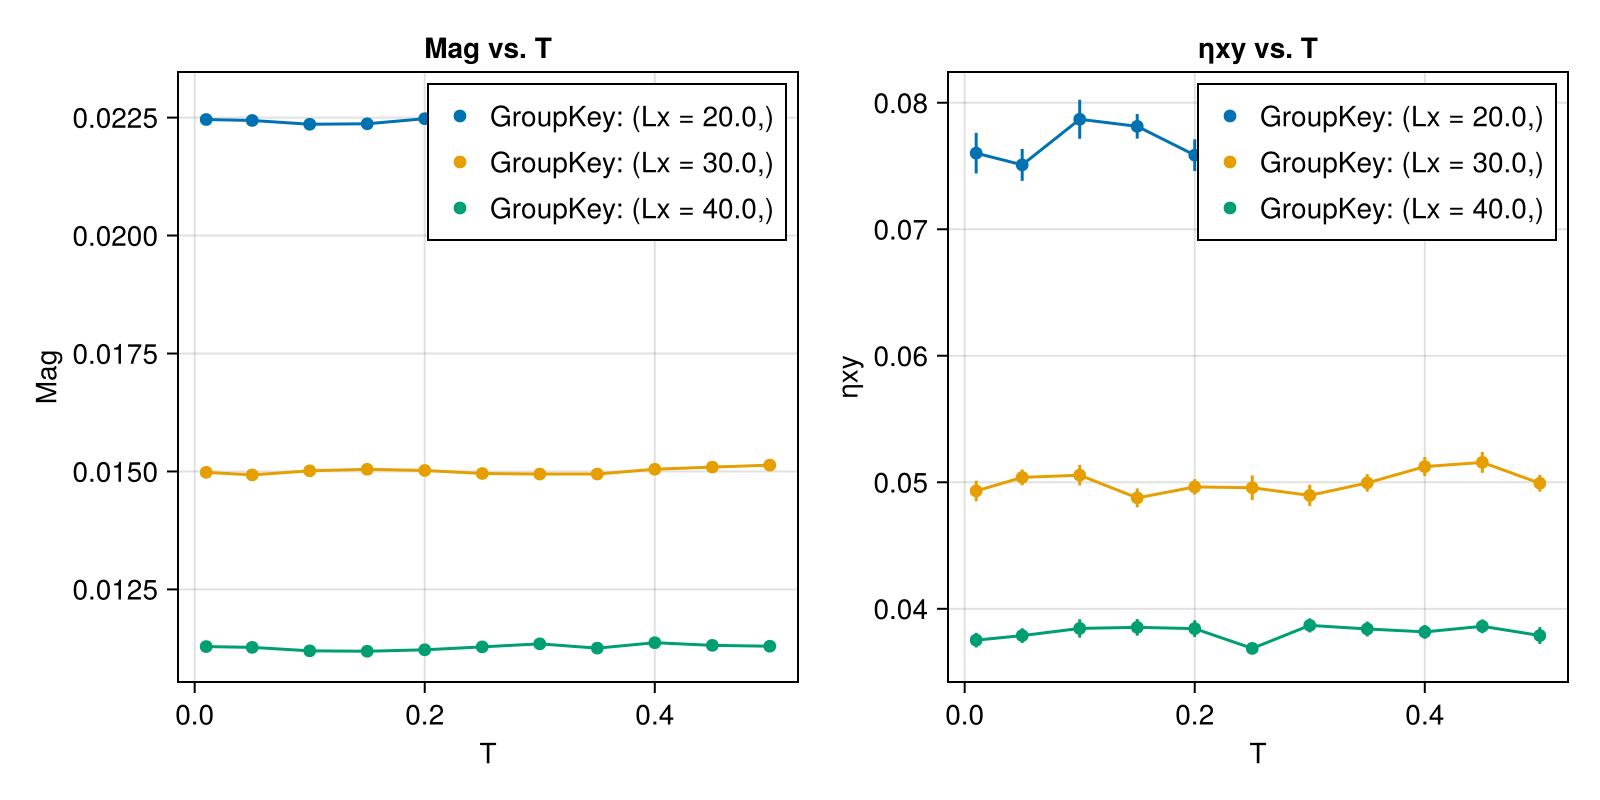

In [63]:
CairoMakie.activate!()

fig = Figure(size=(800, 400))
fig[1,1] = ax_s = Axis(fig, title="Mag vs. T", xlabel="T", ylabel="Mag")
generate_plot!(ax_s, :T, :Mag, :Lx, anneal_results.data; line=true)
fig[1,2] = ax_η = Axis(fig, title="ηxy vs. T", xlabel="T", ylabel="ηxy")
generate_plot!(ax_η, :T, :ηxy, :Lx, anneal_results.data; line=true)
fig

In [36]:
anneal_mctimes = get_mctime_data(anneal_results, :Mag, :ηxy)

MethodError: MethodError: no method matching get_mctime_data(::GroupedJobResult, ::Symbol, ::Symbol)
The function `get_mctime_data` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  get_mctime_data(!Matched::JobResult, ::Any...)
   @ CarloAnalysis ~/.julia/packages/CarloAnalysis/9TxFV/src/JobResults.jl:50


In [37]:
CairoMakie.activate!()
i = 1

fig = Figure(size=(800, 400))
fig[1,1] = ax1 = Axis(fig, title="ηxy vs. Bin #", xlabel="Bin #", ylabel="ηxy")
fig[1,2] = ax2 = Axis(fig, title="ηxy vs. Bin #", xlabel="Bin #", ylabel="ηxy")
lines!(ax1, anneal_mctimes[i][:, :ηxy])
lines!(ax2, anneal_mctimes[i+1][:, :ηxy])
fig

UndefVarError: UndefVarError: `anneal_mctimes` not defined in `Main`
Suggestion: add an appropriate import or assignment. This global was declared but not assigned.

In [49]:
spink_corrs = anneal_results[:spink_corrs]

33-element Vector{Matrix{Measurements.Measurement{Float64}}}:
 [0.0005945 ± 6.4e-6 0.000606 ± 3.9e-6 … 0.0006454 ± 2.3e-6 0.000606 ± 3.9e-6; 0.0006019 ± 3.1e-6 0.0006058 ± 3.4e-6 … 0.0006938 ± 2.8e-6 0.0006354 ± 3.9e-6; … ; 0.0006436 ± 3.5e-6 0.0006937 ± 6.0e-6 … 0.0006438 ± 2.2e-6 0.0006354 ± 4.2e-6; 0.0006019 ± 3.1e-6 0.0006354 ± 3.9e-6 … 0.000631 ± 2.7e-6 0.0006058 ± 3.4e-6]
 [0.0005939 ± 4.5e-6 0.0006026 ± 3.0e-6 … 0.0006553 ± 4.5e-6 0.0006026 ± 3.0e-6; 0.0006045 ± 4.4e-6 0.0006037 ± 4.4e-6 … 0.0007017 ± 4.6e-6 0.0006342 ± 4.4e-6; … ; 0.0006442 ± 3.9e-6 0.0006907 ± 3.6e-6 … 0.0006475 ± 5.5e-6 0.0006354 ± 3.1e-6; 0.0006045 ± 4.4e-6 0.0006342 ± 4.4e-6 … 0.0006389 ± 4.3e-6 0.0006037 ± 4.4e-6]
 [0.0005894 ± 4.7e-6 0.000607 ± 4.2e-6 … 0.0006476 ± 3.8e-6 0.000607 ± 4.2e-6; 0.0006078 ± 3.2e-6 0.0006089 ± 4.3e-6 … 0.0006957 ± 4.6e-6 0.0006393 ± 5.2e-6; … ; 0.0006479 ± 4.6e-6 0.0007047 ± 4.7e-6 … 0.0006606 ± 5.5e-6 0.0006373 ± 4.2e-6; 0.0006078 ± 3.2e-6 0.0006393 ± 5.2e-6 … 0.0006378 ± 3.9e

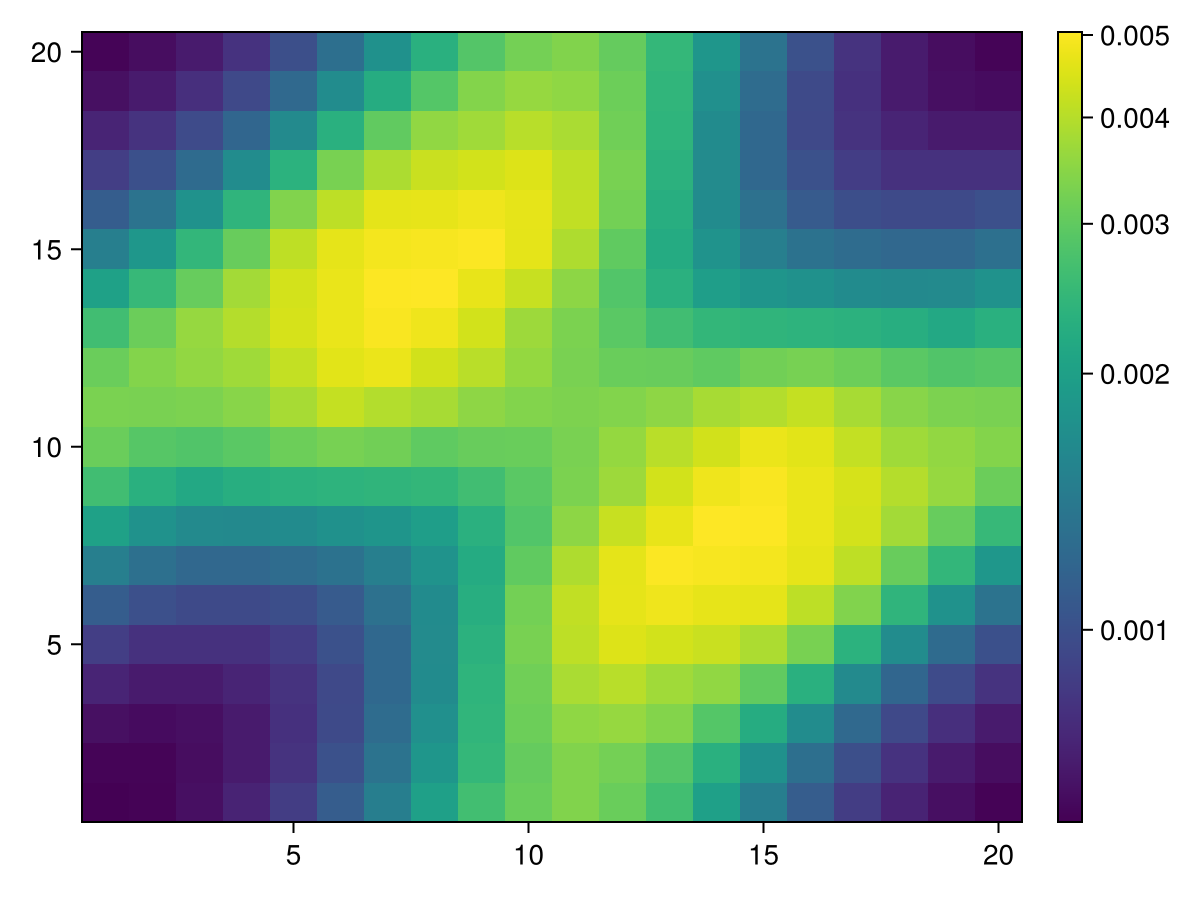

In [50]:
CairoMakie.activate!()
fig = Figure(size=(500, 500))
ax = fig[1,1] = Axis(fig; title="Spin_k")
scale = ReversibleScale(log)
fig, ax, hm = heatmap(getfield.(spink_corrs[1], :val), colorscale=scale)
Colorbar(fig[1, 2], hm)
fig

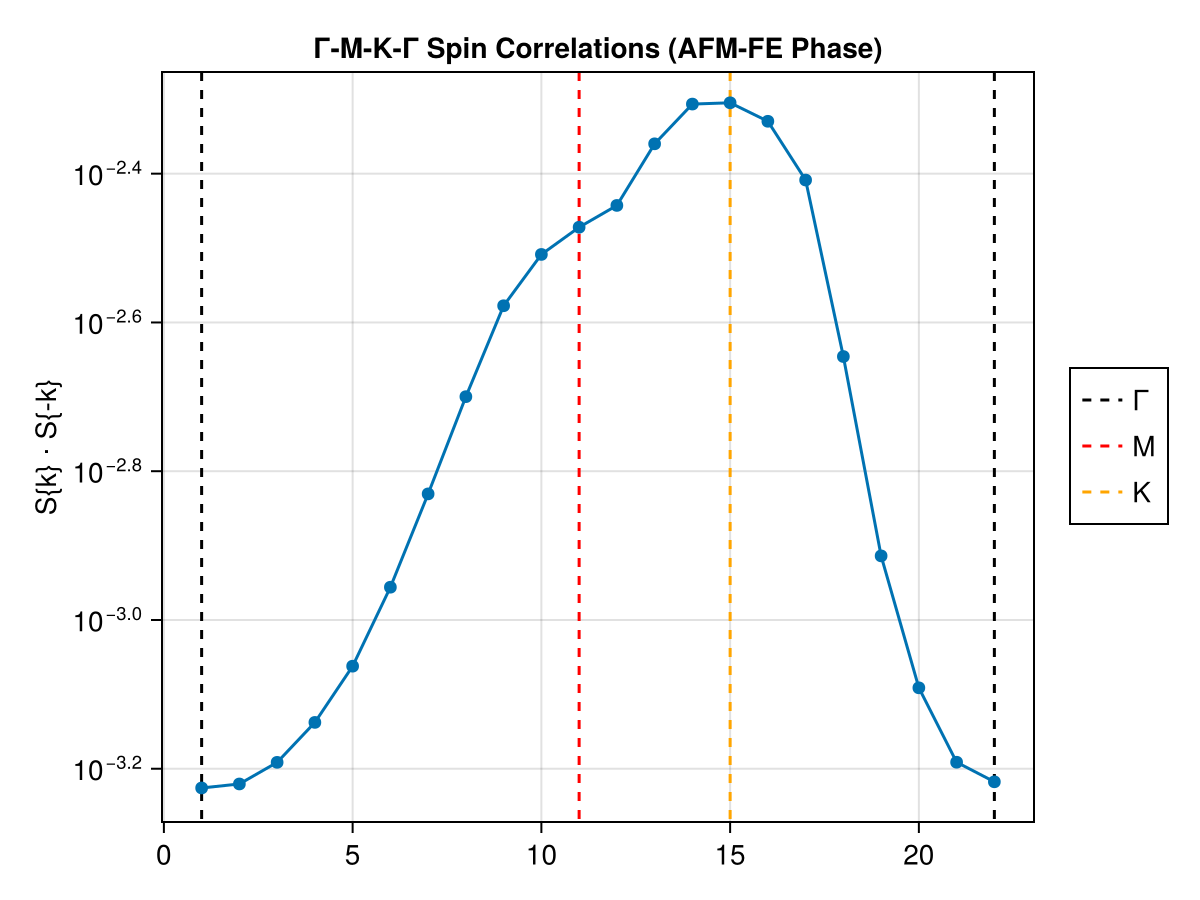

In [53]:
CairoMakie.activate!()
path, M_pos, K_pos = gen_path(size(spink_corrs[1])...)

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Γ-M-K-Γ Spin Correlations (AFM-FE Phase)",
    ylabel="S{k} ⋅ S{-k}",
    yscale=log10
)

min_corr = minimum(getfield.([spink_corrs[1][I...] for I in path], :val))
min_border = 0.9 * min_corr
max_corr = maximum(getfield.([spink_corrs[1][I...] for I in path], :val))
max_border = 1.1 * max_corr
lines!([(1, max_border), (1, min_border)], color=:black, label="Γ", linestyle=:dash)
lines!([(M_pos, max_border), (M_pos, min_border)], color=:red, label="M", linestyle=:dash)
lines!([(K_pos, max_border), (K_pos, min_border)], color=:orange, label="K", linestyle=:dash)
lines!([(length(path), max_border), (length(path), min_border)], color=:black, linestyle=:dash)

for i in [1]
    corrs = [spink_corrs[i][I...] for I in path]
    scatter!(ax, corrs)
    errorbars!(ax, 1:length(path), getfield.(corrs, :val), getfield.(corrs, :err))
    lines!(ax, corrs)
end

ylims!(ax, (min_border, max_border))
Legend(fig[1,2], ax)
fig

In [41]:
CairoMakie.activate!()
Lx, Ly = size(spink_corrs[1])

path = []
pos = (1, 1)
push!(path, pos)
while pos[2] < div(Ly, 2) + 1
    pos = pos .+ (0, 1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
M_pos = length(path)
while pos[2] > div(Ly, 3) + 1
    pos = pos .+ (-2, -1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
K_pos = length(path)
while pos[2] > 1
    pos = pos .+ (1, -1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
println(path)

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Γ-M-K-Γ Spin Correlations (AFM-FE Phase)",
    ylabel="S{k} ⋅ S{-k}",
    yscale=log10
)

min_corr = minimum(getfield.([spink_corrs[1][I...] for I in path], :val))
max_corr = maximum(getfield.([spink_corrs[1][I...] for I in path], :val))
lines!([(1, 2), (1, 1e-9)], color=:black, label="Γ", linestyle=:dash)
lines!([(M_pos, 2), (M_pos, 1e-9)], color=:red, label="M", linestyle=:dash)
lines!([(K_pos, 2), (K_pos, 1e-9)], color=:orange, label="K", linestyle=:dash)
lines!([(length(path), 2), (length(path), 1e-9)], color=:black, linestyle=:dash)

for i in [1]
    corrs = [spink_corrs[i][I...] for I in path]
    scatter!(ax, corrs)
    errorbars!(ax, 1:length(path), getfield.(corrs, :val), getfield.(corrs, :err))
    lines!(ax, corrs)
end

ylims!(ax, (0.8 * min_corr, 1.1 * max_corr))
Legend(fig[1,2], ax)
fig

UndefVarError: UndefVarError: `spink_corrs` not defined in `Main`
Suggestion: add an appropriate import or assignment. This global was declared but not assigned.

In [42]:
CairoMakie.activate!()
Lx, Ly = size(spink_corrs[1])

path = []
pos = (1, 1)
push!(path, pos)
while pos[2] > -div(Ly, 2) + 1
    pos = pos .+ (-1, -1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
M_pos = length(path)
while pos[1] < -div(Lx, 3) + 1
    pos = pos .+ (1, -1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
K_pos = length(path)
while pos[2] < 1
    pos = pos .+ (1, 2)
    push!(path, mod1.(pos, (Lx, Ly)))
end
println(path)

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Γ-M-K-Γ Spin Correlations (AFM-FE Phase)",
    ylabel="S{k} ⋅ S{-k}",
    yscale=log10
)

min_corr = minimum(getfield.([spink_corrs[1][I...] for I in path], :val))
max_corr = maximum(getfield.([spink_corrs[1][I...] for I in path], :val))
lines!([(1, 2), (1, 1e-9)], color=:black, label="Γ", linestyle=:dash)
lines!([(M_pos, 2), (M_pos, 1e-9)], color=:red, label="M", linestyle=:dash)
lines!([(K_pos, 2), (K_pos, 1e-9)], color=:orange, label="K", linestyle=:dash)
lines!([(length(path), 2), (length(path), 1e-9)], color=:black, linestyle=:dash)

for i in [1]
    corrs = [spink_corrs[i][I...] for I in path]
    scatter!(ax, corrs)
    errorbars!(ax, 1:length(path), getfield.(corrs, :val), getfield.(corrs, :err))
    lines!(ax, corrs)
end

ylims!(ax, (0.8 * min_corr, 1.1 * max_corr))
Legend(fig[1,2], ax)
fig

UndefVarError: UndefVarError: `spink_corrs` not defined in `Main`
Suggestion: add an appropriate import or assignment. This global was declared but not assigned.

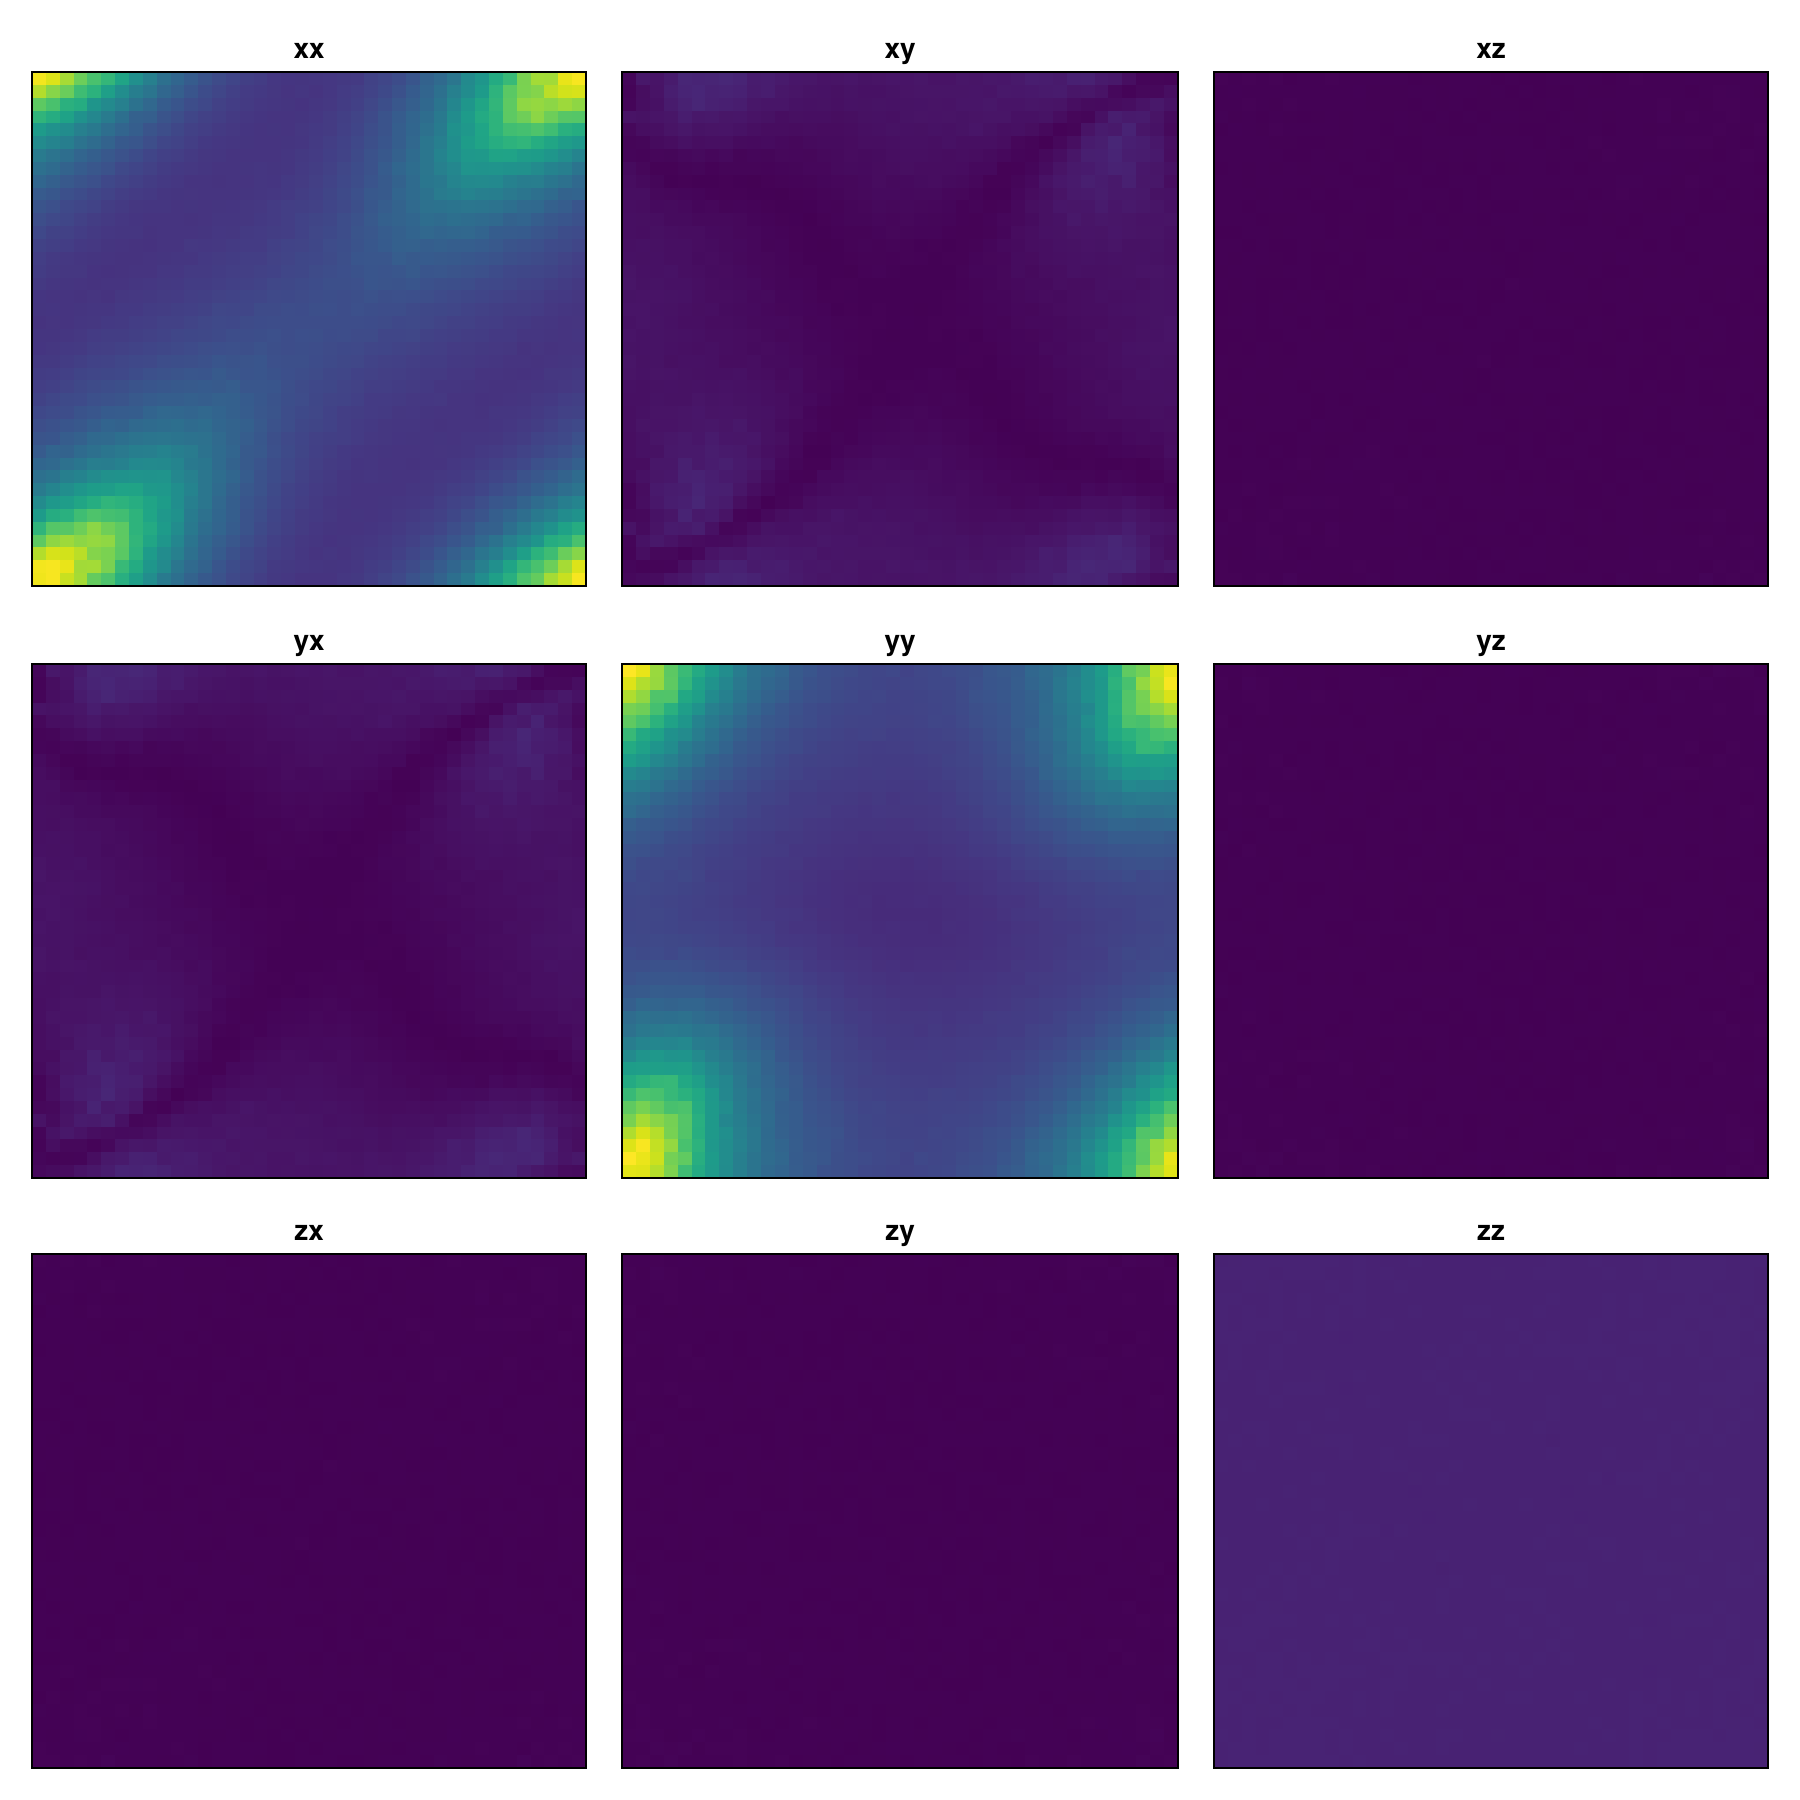

In [43]:
CairoMakie.activate!()

i = 1
Lx = 40
etak_corrs = anneal_results.data[(Lx=Lx,)][:, :etak_corrs]
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
scale = ReversibleScale(log)
corr_matrices = eachslice(etak_corrs[i], dims=(1, 2))
max_corrs = maximum(abs.(etak_corrs[i]))
min_corrs = minimum(abs.(etak_corrs[i]))
for x in 1:3
    for y in 1:3
        fig[x, y] = ax = Axis(fig, title="$(labels[x])$(labels[y])")
        corrs = getindex.(corr_matrices, x, y)
        heatmap!(ax, getfield.(abs.(corrs), :val), colorrange=(0, max_corrs.val))
        hidedecorations!(ax)
    end
end

print("Maximum correlation norm: $max_corrs")
fig

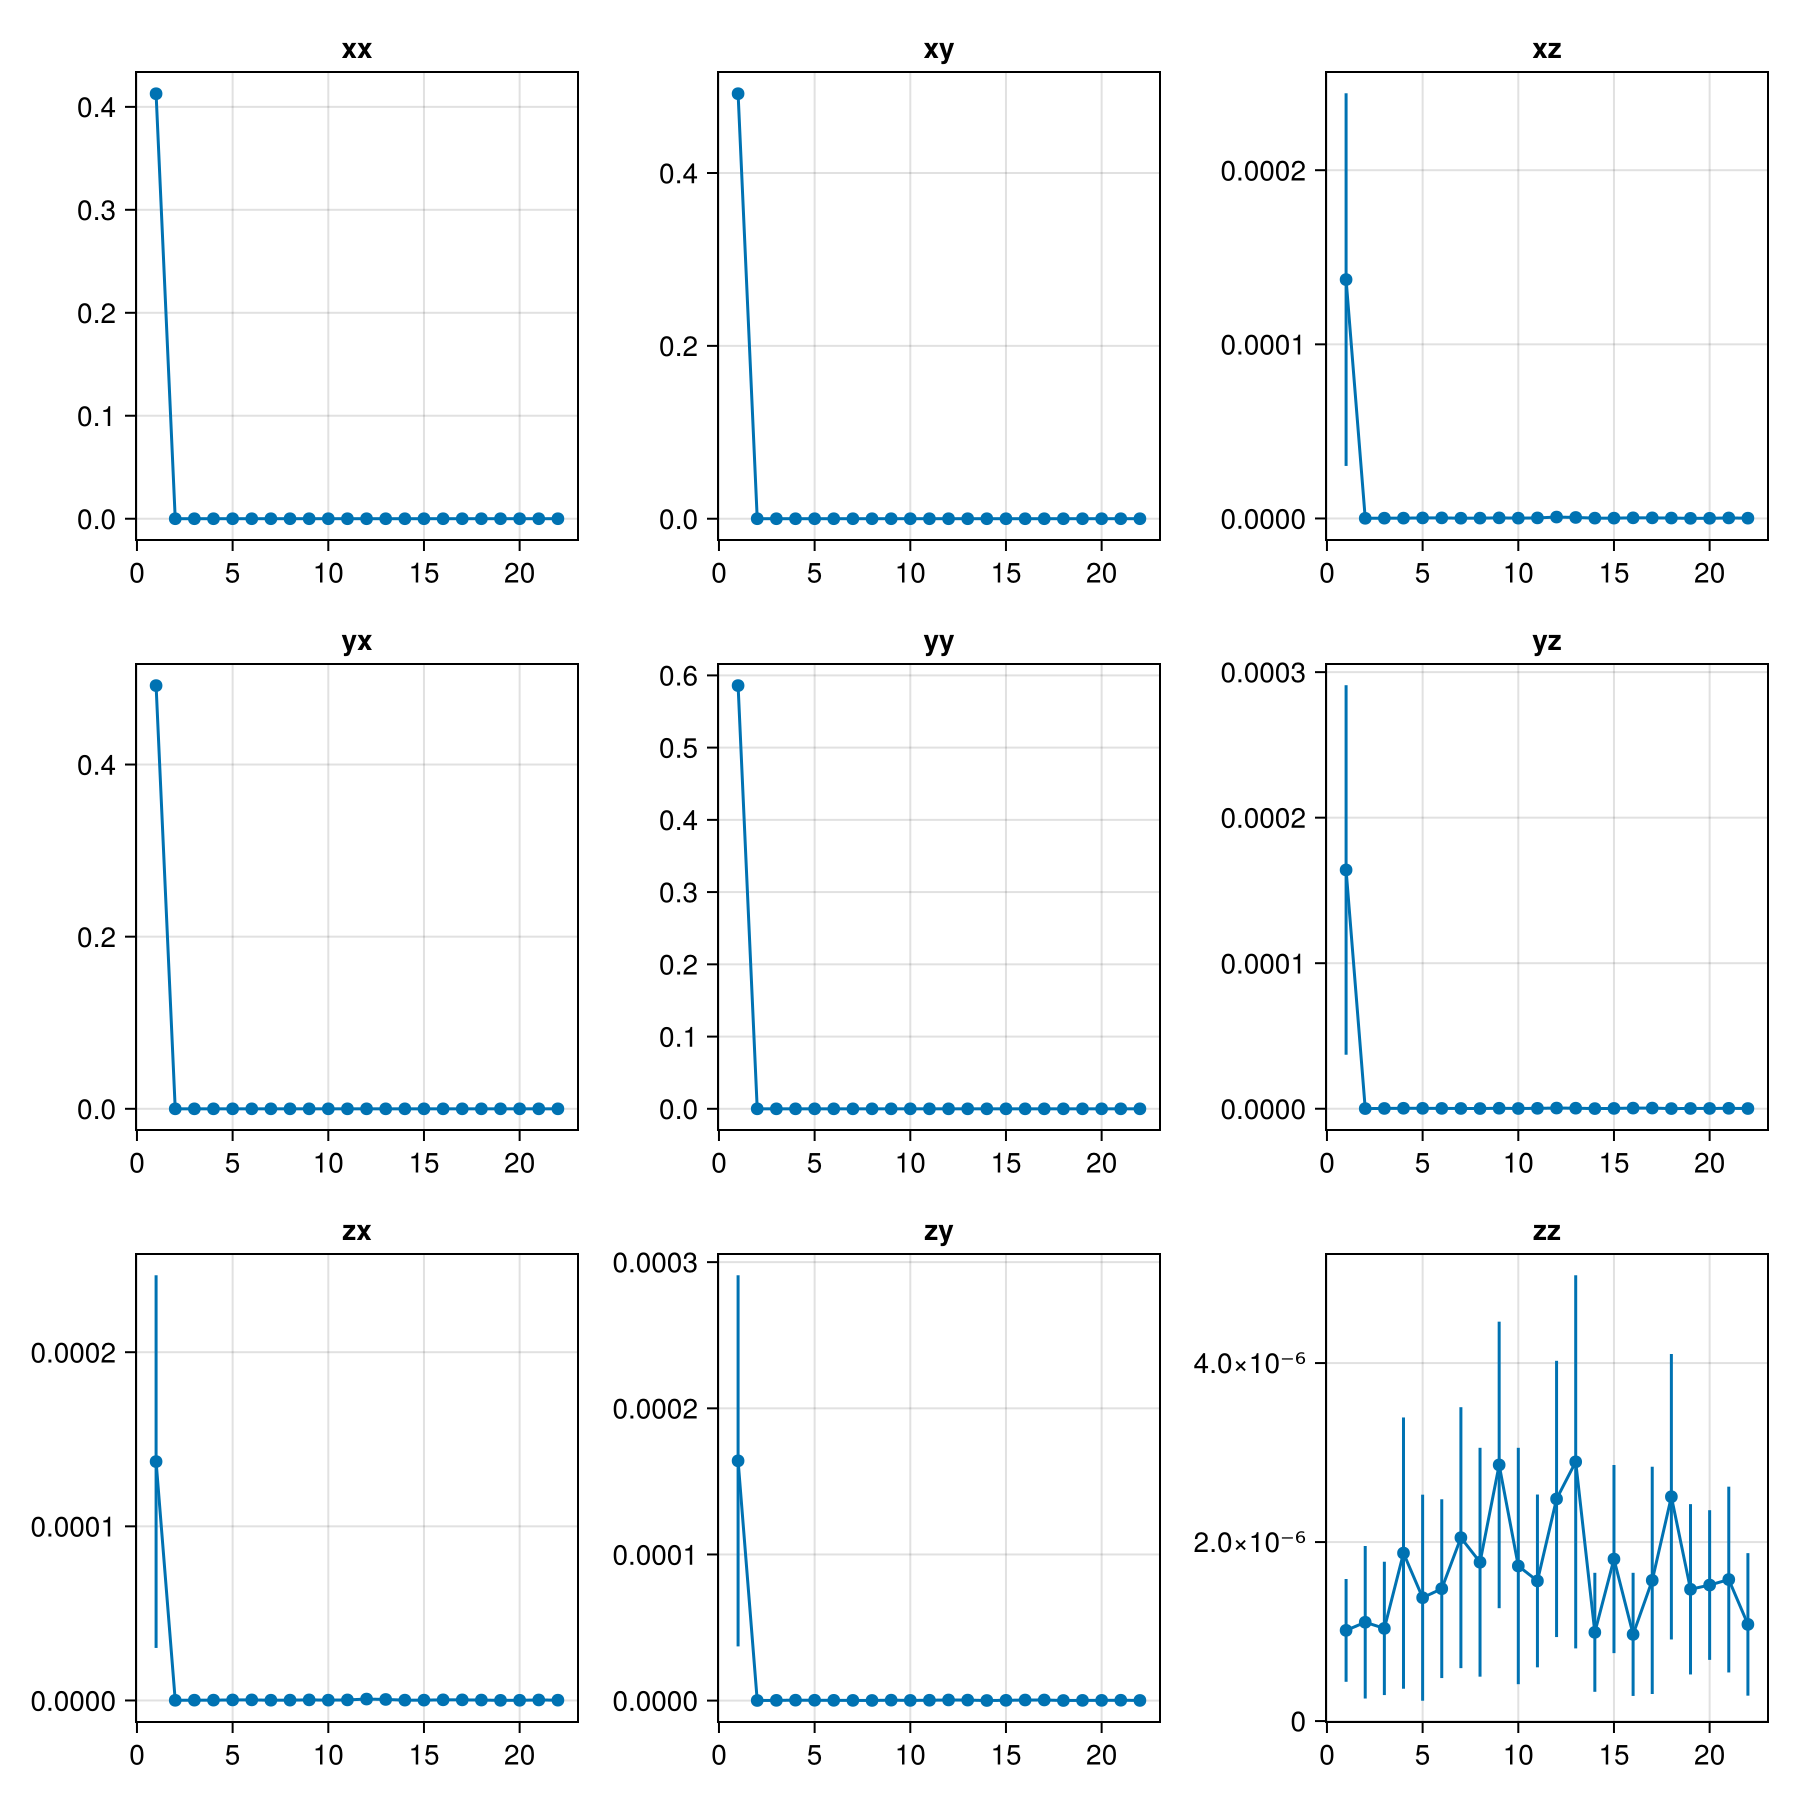

In [ ]:
etak_corrs = eta_results[:etak_corrs]
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
scale = ReversibleScale(log)

axs = Matrix{Axis}(undef, 3, 3)
for x in 1:3
    for y in 1:3
        fig[x, y] = axs[x, y] = Axis(fig, title="$(labels[x])$(labels[y])")
    end
end

for i in [1]
    corr_matrices = collect(eachslice(etak_corrs[i], dims=(1, 2)))
    path, M_pos, K_pos = gen_path(size(corr_matrices)...)
    path_matrices = [corr_matrices[I...] for I in path]
    for x in 1:3
        for y in 1:3
            ax = axs[x, y]
            corrs = abs.(getindex.(path_matrices, x, y))
            corr_vals = getfield.(corrs, :val)
            corr_errs = getfield.(corrs, :err)
            scatter!(ax, corr_vals)
            lines!(ax, corr_vals)
            errorbars!(ax, 1:length(corr_vals), corr_vals, corr_errs)
        end
    end
end

fig